In [1]:
from transformers import AutoTokenizer, AutoConfig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import csv
import glob
import xml.etree.ElementTree as ET
from tqdm import tqdm
from wordcloud import WordCloud
from collections import defaultdict

# Question Parsing

In [2]:
tree = ET.parse('../Dataset/Questions/question_queries_normalized.xml')
root = tree.getroot()
question_queries = []
question_ids = []
question_map = dict()
print("Parsing all question queries")
for doc in tqdm(root):
    doc_dict =  dict()
    for attr in doc:
        attr_type = attr.tag
        attr_content = attr.text
        if attr_type not in doc_dict:
            doc_dict[attr_type.lower()] = ""
        else:
            tmp = doc_dict[attr_type.lower()]
            doc_dict[attr_type.lower()] = [tmp]
        if isinstance(doc_dict[attr_type.lower()], list):
            doc_dict[attr_type.lower()].append(attr_content)
        else:
            doc_dict[attr_type.lower()] = attr_content
    question_str = doc_dict["judul"]
    question_id = str(doc_dict["no"])
    question_map[question_id] = {
        "title": question_str,
        "text": doc_dict["isi"]
    }

    question_str += f'. {doc_dict["isi"]}'
    question_queries.append(question_str)
    question_ids.append(question_id)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 50267.31it/s]

Parsing all question queries


In [3]:
question_map

{'1': {'title': 'cara mengatasi pusing , lemas dan hidung berair',
  'text': 'malam dok , sejak 2 hari yang lalu badan saya pusing dan lemas hari ini hidung saya mengeluarkan ingus terus menerus , bagaimana cara mengatasi nya ya dok ? terima kasih sebelumnya'},
 '2': {'title': 'telinga berdengung sebelah kiri',
  'text': 'selamat pagi dok , saya mau tanya kenapa telinga saya berdenging terus ya dok sudah 6 hari , saya juga sudah ke puskesmas untuk di periksa , kata dokternya telinganya kotor karena di bersihkan dengan cutton buds jadi kotorannya terdorong hingga menutupi gendang telinga , dan saya sudah dikasih obat tetes untuk menghilangkan kotoran , tetapi dengung di telinga saya tidak berkurang sama sekali dok , saran dari dokter seperti apa ?'},
 '3': {'title': 'benjolan di sekitar kelamin',
  'text': 'sore dok . . maaf dok saya sudah 4 hari mengalami benjolan di daerah kemaluan mula-mula benjolan tersebut kecil dan sekarang membesar lalu pecah dok . . rasanya linu dan sakit jika m

# Corpus Parsing

In [4]:
corpus_map = dict()
with open('../Dataset/Corpus/corpus-syifa-normalized.tsv', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in tqdm(reader):
        corpus_map[str(row[0])] = {
            'title': row[2],
            'text': row[1]
        }
       

86731it [00:00, 138388.61it/s]


In [5]:
corpus_map

{'DS-1': {'title': 'mengapa keringat badan sangat berlebihan ?',
  'text': 'selamat malam dokter. ! saya fathurrosi umur 18 tahun saya memiliki masalah berkeringat berlebihan tanpa sebab saya sering sekali berkeringat secara berlebihan padahal saya tidak melakukan kegiatan apapun , teman-teman saya tidak berkeringat malah saya sendiri yang berkeringat , saya kurang pede kalau sudah berkeringat berlebihan seperti itu apakah untuk masalah ini ada tips atau cara mengatasi nya supaya saya bisa menyembuhkan masalah ini. ? mohon bantuannya terima kasih ! salam fathurrosi'},
 'DS-2': {'title': 'mengapa lengan atas sakit walaupun tidak melakukan aktivitas ?',
  'text': 'siang dokter mau tanya ? sudah 4 bulan lengan atas saya sakit jika melakukan pukulan smash atau lob keatas pada badminton . tidak melakukan aktivitas juga sakit . apa yang saya harus lakukan sendiri karena saya tidak mau ke dokter . saya sudah kompres dengan es batu tetapi belum sembuh juga . tolong saran dan informasinya ? ter

In [6]:
tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p2', do_lower_case=True)

In [7]:
print(tokenizer.tokenize("hass", add_special_tokens=True, max_length=512, truncation=True))

['[CLS]', 'has', '##s', '[SEP]']


# Corpus Vocab 

In [8]:
def update_unknown_frequency(unknown_word_freq, tokens, unknown_word_lst):
    if len(tokens) == 0:
        return unknown_word_freq
    prefix = tokens[0]
    is_unknown = False
    for token in tokens:
        if is_unknown:
            if token.startswith("##"):
                prefix += token[2:]
            else:
                is_unknown = False
                unknown_word_freq[prefix] += 1
                unknown_word_lst.append(prefix)
                prefix = token
        else:
            if token.startswith("##"):
                is_unknown = True
                prefix += token[2:]
            else:
                prefix = token
    return unknown_word_freq, unknown_word_lst

In [9]:


unknown_words_corpus = defaultdict(int)
unknown_words_corpus_lst = []
pbar = tqdm(total=len(list(corpus_map.keys())), desc="Check unknown words")
for _, corpus_instance in corpus_map.items():
    tokenized_title = tokenizer.tokenize(corpus_instance['title'], max_length=512, truncation=True)
    tokenized_text = tokenizer.tokenize(corpus_instance['text'], max_length=512, truncation=True)
    tokenized_combined = tokenized_title + tokenized_text
    unknown_words_corpus, unknown_words_corpus_lst = update_unknown_frequency(unknown_words_corpus, tokenized_combined, unknown_words_corpus_lst)
    pbar.update(1)


Check unknown words: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 86682/86731 [00:26<00:00, 3482.49it/s]

In [10]:
sorted_unknown_words_corpus = sorted(unknown_words_corpus.items(), key=lambda x: x[1], reverse=True)    
print(sorted_unknown_words_corpus)

[('bentol', 1846), ('tanyadok', 1579), ('lajang', 1193), ('mimisan', 1075), ('ngilu', 1069), ('dahak', 815), ('kuret', 722), ('tht', 704), ('klikdokter', 656), ('tensi', 646), ('geraham', 638), ('berdahak', 634), ('mengganjal', 625), ('rontgen', 600), ('dokternya', 597), ('obt', 560), ('garuk', 544), ('bernanah', 531), ('thun', 530), ('sufor', 519), ('ingus', 504), ('iud', 502), ('kdang', 484), ('mencret', 477), ('benjolannya', 474), ('momongan', 461), ('trasa', 443), ('alaikum', 443), ('igg', 438), ('gatalnya', 436), ('penyembuhannya', 436), ('sertai', 430), ('kolestrol', 427), ('berbahayakah', 423), ('pnyakit', 423), ('haidnya', 420), ('testpack', 419), ('lukanya', 415), ('ditusuk', 407), ('nyerinya', 400), ('keloid', 400), ('jawabanya', 377), ('biduran', 374), ('periksakan', 371), ('linu', 370), ('panu', 365), ('prut', 359), ('stlah', 354), ('blan', 351), ('bgaimana', 351), ('normalkah', 343), ('kumat', 342), ('bronkitis', 338), ('bahayakah', 337), ('leukosit', 335), ('batuknya', 33

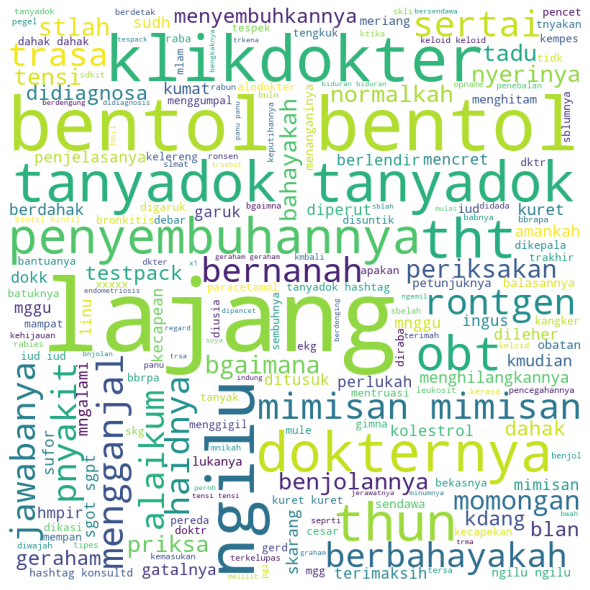

In [11]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(" ".join(unknown_words_corpus_lst))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Question Vocab

In [12]:
unknown_words_question = defaultdict(int)
unknown_words_question_lst = []
pbar = tqdm(total=len(list(question_map.keys())), desc=f"Tokenizing")
for qid, question_instance in question_map.items():
    tokenized_title = []
    tokenized_text = []
    if question_instance['title'] is not None:
        tokenized_title = tokenizer.tokenize(question_instance['title'], max_length=512, truncation=True)
    if question_instance['text'] is not None:
        tokenized_text = tokenizer.tokenize(question_instance['text'], max_length=512, truncation=True)
    tokenized_combined = tokenized_title + tokenized_text
    unknown_words_question, unknown_words_question_lst = update_unknown_frequency(unknown_words_question, tokenized_combined, unknown_words_question_lst)
    pbar.update(1)


Tokenizing:   0%|                                                                                                                                                                                                                                       | 0/50 [00:00<?, ?it/s]

In [13]:
sorted_unknown_words_question = sorted(unknown_words_question.items(), key=lambda x: x[1], reverse=True)    
print(sorted_unknown_words_question)

[('mimisan', 4), ('berbahayakah', 3), ('aloe', 3), ('panic', 3), ('ligamen', 3), ('maladaptive', 2), ('daydreaming', 2), ('lebam', 2), ('belekan', 2), ('denyutan', 2), ('wassalamualaikum', 2), ('hbv', 2), ('sgpt', 2), ('mmol', 2), ('nyut', 2), ('indung', 2), ('disorder', 2), ('ingus', 1), ('berdengung', 1), ('berdenging', 1), ('dokternya', 1), ('cutton', 1), ('buds', 1), ('kotorannya', 1), ('dengung', 1), ('linu', 1), ('melamun', 1), ('berkhayal', 1), ('reflek', 1), ('mhswi', 1), ('smst', 1), ('poltekkes', 1), ('atensinya', 1), ('nunjuk', 1), ('merengeknya', 1), ('kebentur', 1), ('menuruni', 1), ('berkemih', 1), ('berkunang', 1), ('kunang', 1), ('silau', 1), ('taapi', 1), ('perantau', 1), ('belekannya', 1), ('pengelihatan', 1), ('menyembuhannya', 1), ('gastritis', 1), ('analisisnya', 1), ('epigastric', 1), ('ngeden', 1), ('babnya', 1), ('cemaskan', 1), ('meriang', 1), ('ekg', 1), ('sekarangpun', 1), ('pereda', 1), ('dipangkal', 1), ('mengganjal', 1), ('meraskan', 1), ('nemenukan', 1), 

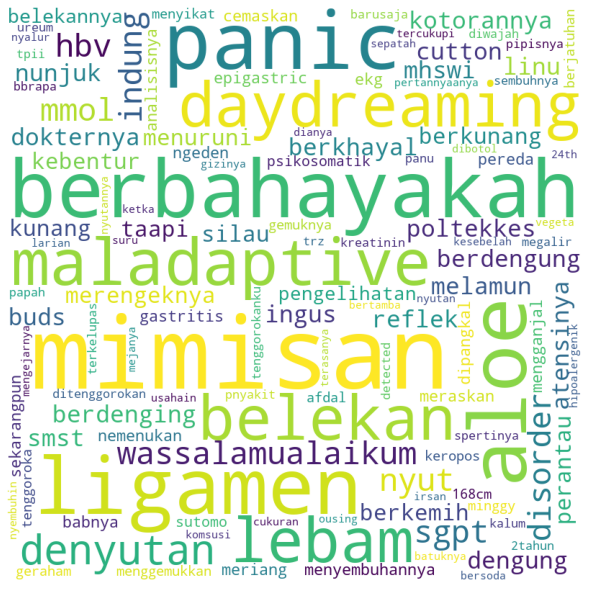

In [14]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(" ".join(unknown_words_question_lst))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# False Positive Check

In [15]:
with open('../Results/syifa_results_full_tydi.json', 'r') as f:
    res_json = json.load(f)

with open('../Dataset/Questions/question-syifa-test.json', 'r') as f:
    gold_json =  json.load(f)

In [16]:
res_json

[{'question': {'id': '1',
   'title': 'cara mengatasi pusing , lemas dan hidung berair',
   'text': 'malam dok , sejak 2 hari yang lalu badan saya pusing dan lemas hari ini hidung saya mengeluarkan ingus terus menerus , bagaimana cara mengatasi nya ya dok ? terima kasih sebelumnya'},
  'ctxs': [{'id': 'TD-7479',
    'title': 'trimaksh dok atas info nya , tetapi',
    'text': 'trimaksh dok atas info nya , tetapi saya sudah coba brusaha meng hentikan nya tetapi sulit sekali dok , bgai mana cara menghentikan nya',
    'score': '613.2973'},
   {'id': 'TD-11694',
    'title': 'selamat malam dok . maaf nie ! saya mau tanya ? telinga saya yang sebelah kanan kemasukan air , sampai sekarang masih sakit ! dan pndngaran saya yang sebelah kanan agak trganggu ! kira-kira .',
    'text': 'selamat malam dok . maaf nie ! saya mau tanya ? telinga saya yang sebelah kanan kemasukan air , sampai sekarang masih sakit ! dan pndngaran saya yang sebelah kanan agak trganggu ! kira-kira apa obat y dok ? m0 h0 n

In [17]:
neg_rels = dict()
for row in gold_json:
    qid = row['question']['id']
    neg_rel = []
    for neg_ctx in row['neg_ctxs']:
        neg_rel.append(neg_ctx['id'])
    neg_rels[qid] = neg_rel

In [18]:
unknown_words_all_neg_ctxs = dict()
unknown_words_all_neg_ctxs_lst = dict()
for qrow in res_json:
    qid = qrow['question']['id']
    unknown_words_neg_ctxs = defaultdict(int)
    unknown_words_neg_ctxs_lst = []
    for ctx in qrow['ctxs']:
        pid = ctx['id']

        if pid in neg_rels[qid]:
            tokenized_title = []
            tokenized_text = []
            if ctx['title'] is not None:
                tokenized_title = tokenizer.tokenize(ctx['title'], max_length=512, truncation=True)
            if question_instance['text'] is not None:
                tokenized_text = tokenizer.tokenize(ctx['text'], max_length=512, truncation=True)
            tokenized_combined = tokenized_title + tokenized_text
            unknown_words_neg_ctxs, unknown_words_neg_ctxs_lst = update_unknown_frequency(unknown_words_neg_ctxs, tokenized_combined, unknown_words_neg_ctxs_lst)
    unknown_words_all_neg_ctxs[qid] = sorted(unknown_words_neg_ctxs.items(), key=lambda x: x[1], reverse=True) 
    unknown_words_all_neg_ctxs_lst[qid] = unknown_words_neg_ctxs_lst

In [19]:
unknown_words_all_neg_ctxs

{'1': [],
 '2': [],
 '3': [],
 '4': [],
 '5': [],
 '6': [],
 '7': [],
 '8': [],
 '9': [],
 '10': [],
 '11': [],
 '12': [],
 '14': [],
 '15': [('eskrim', 1), ('mwngandung', 1)],
 '16': [('mengganjal', 2), ('mengedip', 1)],
 '17': [],
 '19': [],
 '20': [],
 '21': [],
 '23': [],
 '25': [],
 '26': [],
 '27': [],
 '28': [],
 '29': [],
 '30': [],
 '31': [],
 '32': [('ditusuk', 2),
  ('ceasar', 1),
  ('nmelahirkan', 1),
  ('nyerinya', 1),
  ('regards', 1)],
 '33': [],
 '34': [],
 '35': [],
 '36': [],
 '37': [],
 '38': [],
 '39': [],
 '41': [],
 '42': [],
 '43': [('baikan', 1)],
 '44': [('meberikan', 2), ('morniaga', 1), ('sufor', 1), ('alerginya', 1)],
 '45': [],
 '46': [],
 '47': [],
 '48': [],
 '49': [('ciprofloxaxin', 1),
  ('biotik', 1),
  ('bagiang', 1),
  ('linu', 1),
  ('ketulang', 1)],
 '50': [('thq', 1), ('adan', 1), ('erut', 1)]}

# True Positive Check

In [20]:
pos_rels = dict()
for row in gold_json:
    qid = row['question']['id']
    pos_rel = []
    for pos_ctx in row['ctxs']:
        pos_rel.append(pos_ctx['id'])
    pos_rels[qid] = pos_rel

In [21]:
unknown_words_all_pos_ctxs = dict()
unknown_words_all_pos_ctxs_lst = dict()
for qrow in res_json:
    qid = str(qrow['question']['id'])
    unknown_words_pos_ctxs = defaultdict(int)
    unknown_words_pos_ctxs_lst = []
    for ctx in qrow['ctxs']:
        pid = ctx['id']
        if pid in pos_rels[qid]:
            tokenized_title = []
            tokenized_text = []
            if ctx['title'] is not None:
                tokenized_title = tokenizer.tokenize(ctx['title'], max_length=512, truncation=True)
            if question_instance['text'] is not None:
                tokenized_text = tokenizer.tokenize(ctx['text'], max_length=512, truncation=True)
            tokenized_combined = tokenized_title + tokenized_text
            unknown_words_pos_ctxs, unknown_words_pos_ctxs_lst = update_unknown_frequency(unknown_words_pos_ctxs, tokenized_combined, unknown_words_pos_ctxs_lst)
    unknown_words_all_pos_ctxs[qid] = sorted(unknown_words_pos_ctxs.items(), key=lambda x: x[1], reverse=True) 
    unknown_words_all_pos_ctxs_lst[qid] = unknown_words_pos_ctxs_lst

In [22]:
unknown_words_all_pos_ctxs

{'1': [],
 '2': [('berdengung', 6),
  ('ttng', 2),
  ('beringus', 2),
  ('konfirmasinya', 2),
  ('aslm', 1),
  ('kalaw', 1),
  ('asslm', 1),
  ('kluhan', 1),
  ('mngidap', 1),
  ('mohin', 1),
  ('terimakasi', 1),
  ('wsslm', 1)],
 '3': [],
 '4': [('pendrita', 2), ('intsan', 1)],
 '5': [],
 '6': [('tenguk', 1),
  ('perlukah', 1),
  ('psikiater', 1),
  ('sasha', 1),
  ('menghantui', 1),
  ('dikucilkan', 1),
  ('histeris', 1),
  ('cnderung', 1),
  ('mmkir', 1),
  ('bukn', 1),
  ('mnyalah', 1),
  ('sendri', 1),
  ('shngga', 1),
  ('mnimbulkn', 1),
  ('brfikir', 1),
  ('mengahri', 1),
  ('khlangan', 1),
  ('nfsu', 1),
  ('brat', 1),
  ('smkin', 1),
  ('mnurun', 1),
  ('ucapkn', 1),
  ('krluarganya', 1),
  ('tida', 1),
  ('napsu', 1),
  ('hkan', 1),
  ('bdanpun', 1),
  ('pakah', 1),
  ('noviandi', 1),
  ('dangan', 1),
  ('menertawakan', 1),
  ('berucap', 1),
  ('parno', 1),
  ('uring', 1),
  ('uringan', 1)],
 '7': [],
 '8': [],
 '9': [],
 '10': [],
 '11': [('terlau', 1), ('tiru', 1)],
 '12':

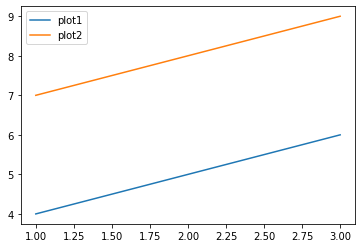

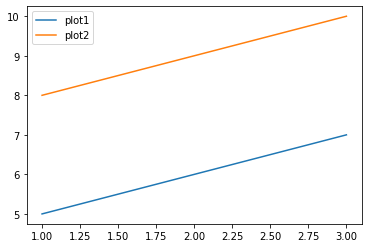

In [23]:
import matplotlib.pyplot as plt

plt.figure()
x = [1,2,3]
y = [4,5,6]
y2 = [7,8,9]
plt.plot(x, y, label='plot1')
plt.plot(x, y2, label='plot2')
plt.legend()
plt.savefig('test.png')

plt.figure()
x = [1,2,3]
y = [5,6,7]
y2 = [8,9,10]
plt.plot(x, y, label='plot1')
plt.plot(x, y2, label='plot2')
plt.legend()
plt.savefig('test2.png')

# Dataset Analysis

In [1]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/mk1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import numpy as np

In [3]:
import json

syifa_questions = []
pids = []
with open('../Dataset/Questions/question-syifa-test.json', 'r') as f:
    syifa_data = json.load(f)
    for row in syifa_data:
        full_text_question = f"{row['question']['text']}. {row['question']['title']}"
        syifa_questions.append(full_text_question)

In [4]:
import csv
syifa_passages = []
with open('../Dataset/Corpus/corpus-syifa-normalized.tsv', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        text = row[1]
        title = row[2]
        full_text = f"{text}. {title}"
        syifa_passages.append(full_text)

In [5]:
from tqdm import tqdm

def gen_ngrams_set(sentences, max_tokens=512):
    unigrams = set()
    bigrams = set()
    trigrams = set()
    for sentence in tqdm(sentences):
        tokenized_sentence = list(word_tokenize(sentence.lower()))[:max_tokens]
        for word in tokenized_sentence:
            if word.isalpha():
                unigrams.add(word.lower())
        for i in range(len(tokenized_sentence)-1):
            if tokenized_sentence[i].isalpha() and tokenized_sentence[i+1].isalpha():
                bigrams.add(f"{tokenized_sentence[i].lower()} {tokenized_sentence[i+1].lower()}")
        for i in range(len(tokenized_sentence)-2):
            if tokenized_sentence[i].isalpha() and tokenized_sentence[i+1].isalpha() and tokenized_sentence[i+2].isalpha():
                trigrams.add(f"{tokenized_sentence[i].lower()} {tokenized_sentence[i+1].lower()} {tokenized_sentence[i+2].lower()}")
    return unigrams, bigrams, trigrams

In [6]:
syifa_unigrams_question, syifa_bigrams_question, syifa_trigrams_question = gen_ngrams_set(syifa_questions)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 223.81it/s]


In [7]:
syifa_unigrams_passage, syifa_bigrams_passage, syifa_trigrams_passage = gen_ngrams_set(syifa_passages)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86731/86731 [00:50<00:00, 1713.97it/s]


In [8]:
def common_unique_terms_analysis(texts, other_unigrams, other_bigrams, other_trigrams):
    unigrams, bigrams, trigrams = gen_ngrams_set(texts)
    combined_unigrams, combined_bigrams, combined_trigrams = unigrams.intersection(other_unigrams), bigrams.intersection(other_bigrams), trigrams.intersection(other_trigrams)
    print(f"Unigram overlap percentage: {len(combined_unigrams)/len(other_unigrams)*100}")
    print(f"Bigram overlap percentage: {len(combined_bigrams)/len(other_bigrams)*100}")
    print(f"Trigram overlap percentage: {len(combined_trigrams)/len(other_trigrams)*100}")
    return combined_unigrams, combined_bigrams, combined_trigrams

def common_unique_terms_frequency_analysis(texts, combined_unigrams, combined_bigrams, combined_trigrams, max_tokens=512):
    combined_unigrams_cnt = 0
    combined_bigrams_cnt = 0
    combined_trigrams_cnt = 0

    total_unigrams_cnt = 0
    total_bigrams_cnt = 0
    total_trigrams_cnt = 0

    for text in texts:
        tokenized_text = list(word_tokenize(text))[:max_tokens]
        for i in range(len(tokenized_text)-1):
            unigram = tokenized_text[i:i+1]
            bigram = tokenized_text[i:i+2]
            trigram = tokenized_text[i:i+3]
            total_unigrams_cnt += 1 
            total_bigrams_cnt +=1 if len(bigram)==2 else 0
            total_trigrams_cnt +=1 if len(trigram)==3 else 0
            unigram = unigram[0]
            bigram = ' '.join(bigram)
            trigram = ' '.join(trigram)
            if unigram in combined_unigrams:
                combined_unigrams_cnt += 1
            if bigram in combined_bigrams:
                combined_bigrams_cnt += 1
            if trigram in combined_trigrams:
                combined_trigrams_cnt += 1

    print(f"Common unigrams percentage: {combined_unigrams_cnt/total_unigrams_cnt*100}")
    print(f"Common bigrams percentage: {combined_bigrams_cnt/total_bigrams_cnt*100}")
    print(f"Common trigrams percentage: {combined_trigrams_cnt/total_trigrams_cnt*100}")

def token_statistics(texts, max_token=512):
    token_len_texts = []
    truncated_text_cnt = 0
    for text in texts:
        tokenized_text = list(word_tokenize(text))
        token_len_texts.append(len(tokenized_text))
        truncated_text_cnt += 1 if len(tokenized_text) > max_token else 0
    token_len_texts = np.array(token_len_texts)
    
    print(f"Mean: {np.mean(token_len_texts)}")
    print(f"Median: {np.median(token_len_texts)}")
    print(f"Min: {min(token_len_texts)}")
    print(f"Max: {max(token_len_texts)}")
    print(f"Truncated percentage: {truncated_text_cnt/len(texts)*100}")

def pair_count(filename):
    pos_ctx_cnts = []
    neg_ctx_cnts = []
    with open(filename, 'r') as f:
        data = json.load(f)
    data = [row for row in data if len(row['positive_ctxs']) > 0]
    q_nums = len(data)
    for row in data:
        pos_ctx_cnts.append(len(row['positive_ctxs']))
        neg_ctx_cnts.append(len(row['negative_ctxs']))
    print(f"#Questions: {q_nums}")
    print(f"#Positive contexts: {sum(pos_ctx_cnts)/len(pos_ctx_cnts)}")
    print(f"#Negative contexts: {sum(neg_ctx_cnts)/len(neg_ctx_cnts)}")

        
        

## A. Mr Tydi

### Question Analysis

#### 1. Unique Terms Analysis

In [111]:
import json
tydi_questions = []
with open('../Dataset/Questions/tydi-indo-train.json', 'r') as f:
        tydi_data = json.load(f)
        for row in tydi_data:
            tydi_questions.append(row['question'])

In [112]:
combined_unigrams_question, combined_bigrams_question, combined_trigrams_question = common_unique_terms_analysis(tydi_questions, syifa_unigrams_question, syifa_bigrams_question, syifa_trigrams_question)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4902/4902 [00:00<00:00, 10734.89it/s]

Unigram overlap percentage: 30.05050505050505
Bigram overlap percentage: 2.7761370348493797
Trigram overlap percentage: 0.18472906403940886


In [113]:
combined_unigrams_question

{'ac',
 'ada',
 'adalah',
 'air',
 'akan',
 'alergi',
 'anak',
 'ani',
 'apa',
 'apakah',
 'aqua',
 'arti',
 'asam',
 'atas',
 'atau',
 'badan',
 'bagaimana',
 'bagian',
 'bahan',
 'bahaya',
 'banjir',
 'banyak',
 'baru',
 'batu',
 'bayi',
 'bekerja',
 'belakang',
 'berapa',
 'berat',
 'berbahaya',
 'berbicara',
 'berhasil',
 'berubah',
 'besar',
 'biasa',
 'bisa',
 'buah',
 'bulan',
 'buntu',
 'caesar',
 'cara',
 'cepat',
 'cerita',
 'daerah',
 'dalam',
 'dan',
 'dapat',
 'darah',
 'dari',
 'demam',
 'dengan',
 'depresi',
 'di',
 'diberi',
 'dingin',
 'dipakai',
 'disebut',
 'dna',
 'dokter',
 'dulu',
 'efek',
 'formula',
 'fungsi',
 'gangguan',
 'gejala',
 'gendang',
 'gerakan',
 'gigi',
 'gizi',
 'hal',
 'hanya',
 'hari',
 'harus',
 'hati',
 'hepatitis',
 'hidup',
 'ibu',
 'instan',
 'istri',
 'itu',
 'jadi',
 'jam',
 'jantung',
 'jika',
 'john',
 'juga',
 'kah',
 'kali',
 'kan',
 'kandungan',
 'kantor',
 'karena',
 'kata',
 'ke',
 'kedalam',
 'kehamilan',
 'keluar',
 'keluarga',
 '

In [114]:
combined_bigrams_question

{'ada cara',
 'ada di',
 'apa nama',
 'apa saja',
 'apa yang',
 'apakah ada',
 'apakah arti',
 'apakah bisa',
 'apakah depresi',
 'apakah itu',
 'arti dari',
 'badan terasa',
 'bagaimana cara',
 'berapa hari',
 'berapa lama',
 'berubah menjadi',
 'bisa mengalami',
 'dalam satu',
 'dapat mempengaruhi',
 'di daerah',
 'di kota',
 'di mana',
 'gendang telinga',
 'itu kan',
 'keluar dari',
 'lama di',
 'lapisan kulit',
 'menggunakan produk',
 'mi instan',
 'nama penyakit',
 'pada hari',
 'pada saat',
 'pada suatu',
 'pada tahun',
 'penyakit jantung',
 'penyakit yang',
 'rumah sakit',
 'sakit kepala',
 'salah satu',
 'sepeda motor',
 'usus buntu',
 'yang ada',
 'yang di',
 'yang disebut',
 'yang sudah',
 'yang tergolong',
 'yang tinggal'}

In [115]:
combined_trigrams_question

{'apakah arti dari', 'nama penyakit yang', 'yang ada di'}

#### 2. Total Unique Intersection Terms Count

In [116]:
common_unique_terms_frequency_analysis(syifa_questions, combined_unigrams_question, combined_bigrams_question, combined_trigrams_question)

Common unigrams percentage: 38.37764144512611
Common bigrams percentage: 2.0790729379686437
Common trigrams percentage: 0.10384215991692627


#### 3. Token Statistics

In [117]:
token_statistics(tydi_questions)

Mean: 6.2144022847817215
Median: 6.0
Min: 3
Max: 15
Truncated percentage: 0.0


### Corpus Analysis

#### 1. Unique Terms Analysis

In [118]:
import json
tydi_corpus = []
tydi_pid = []
with open('../Dataset/Questions/tydi-indo-train.json', 'r') as f:
        tydi_data = json.load(f)
        for row in tqdm(tydi_data):
            for ctx in row['positive_ctxs']:
                if ctx['docid'] not in tydi_pid:
                    full_text = f"{ctx['text']}. {ctx['title']}"
                    tydi_corpus.append(full_text)
                    tydi_pid.append(ctx['docid'])
            for ctx in row['negative_ctxs']:
                if ctx['docid'] not in tydi_pid:
                    full_text = f"{ctx['text']}. {ctx['title']}"
                    tydi_corpus.append(full_text)
                    tydi_pid.append(ctx['docid'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4902/4902 [03:57<00:00, 20.67it/s]


In [119]:
combined_unigrams_passage, combined_bigrams_passage, combined_trigrams_passage = common_unique_terms_analysis(tydi_corpus, syifa_unigrams_passage, syifa_bigrams_passage, syifa_trigrams_passage)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100331/100331 [01:15<00:00, 1324.01it/s]

Unigram overlap percentage: 34.901491840811985
Bigram overlap percentage: 16.319995114992732
Trigram overlap percentage: 3.5660564677984987


In [120]:
combined_unigrams_passage

{'tryptophan',
 'cetuskan',
 'menampung',
 'foris',
 'pulangnya',
 'bab',
 'kampus',
 'teropong',
 'maligna',
 'edward',
 'ceraikan',
 'katerina',
 'kenan',
 'geografisnya',
 'palah',
 'petis',
 'pelacuran',
 'sesaknya',
 'leu',
 'berguling',
 'berharga',
 'petang',
 'wina',
 'survey',
 'lionel',
 'karenakan',
 'atau',
 'prakterk',
 'diolesi',
 'teenage',
 'z',
 'subarachnoid',
 'saring',
 'dilayar',
 'lancip',
 'penumpang',
 'diajak',
 'gusi',
 'swadana',
 'gosong',
 'choice',
 'akhi',
 'penggemar',
 'foundation',
 'mengharapkan',
 'viky',
 'bts',
 'alamatnya',
 'yudistira',
 'merapihkan',
 'onset',
 'dewa',
 'mgk',
 'penderitanya',
 'mimisan',
 'poliklinik',
 'agoes',
 'lentera',
 'bendan',
 'dilalukan',
 'mendiagnosisnya',
 'bdsm',
 'halis',
 'sembur',
 'bersiap',
 'ninety',
 'temperamen',
 'poduk',
 'hiposmia',
 'uapnya',
 'menyemburkan',
 'pedati',
 'terdiam',
 'dicari',
 'sphagnum',
 'ganggang',
 'mangunkusumo',
 'imah',
 'ayam',
 'napak',
 'mwu',
 'allan',
 'melahirkan',
 'pelep

In [121]:
combined_bigrams_passage

{'bila jumlahnya',
 'of food',
 'ada obatnya',
 'dan senam',
 'should have',
 'penanganan darah',
 'sesekali saja',
 'tak pernah',
 'harus digunakan',
 'dikarenakan belum',
 'peluang besar',
 'banyak tekanan',
 'kotak tidak',
 'trauma akan',
 'bisa berupa',
 'lain akan',
 'hasilnya negatif',
 'dia mengalami',
 'meskipun yang',
 'semua karena',
 'scan pun',
 'terlalu berbahaya',
 'seimbang di',
 'yang disebutnya',
 'itu sel',
 'orang hiv',
 'tarakan dan',
 'alami yang',
 'dan kantor',
 'dan body',
 'makin kuat',
 'kendala pada',
 'pada pasir',
 'estimasi waktu',
 'biasanya diadakan',
 'perkembangan otak',
 'dari mata',
 'dan keluarganya',
 'bahaya setelah',
 'yang pusing',
 'badan seseorang',
 'kecil sudah',
 'sangat terpaksa',
 'stand by',
 'sebelum memberikan',
 'mengganggu dalam',
 'fibrosis paru',
 'boleh mengenakan',
 'sudah pensiun',
 'untuk katarak',
 'sama masih',
 'untuk melangkah',
 'dari lubang',
 'jumat pagi',
 'butir setiap',
 'masih sensitif',
 'pun hanya',
 'dan donor',
 

In [122]:
combined_trigrams_passage

{'tidak ada nama',
 'karena sesuatu hal',
 'jauh di atas',
 'sapi atau susu',
 'dan yang jahat',
 'kembali ke jakarta',
 'terjadi saat ini',
 'mencegah kanker sel',
 'bisa terlalu lama',
 'adalah makanan yang',
 'berwarna putih susu',
 'penyebab rasa nyeri',
 'yang lain maka',
 'tahun dan bersekolah',
 'di jakarta ada',
 'obat dan perawatan',
 'tahun ini tidak',
 'air di pantai',
 'ini banyak yang',
 'air perasan jeruk',
 'di bulan november',
 'mendapatkan penjelasan yang',
 'di antara batang',
 'efek yang berlebihan',
 'di sini bisa',
 'dan dimasukkan kedalam',
 'bekerja dengan baik',
 'dapat di turunkan',
 'baru pertama kalinya',
 'saya secara pribadi',
 'sama halnya dengan',
 'tahu lebih banyak',
 'dengan orang biasa',
 'ini tidak dapat',
 'terus di daerah',
 'penyakit seperti kanker',
 'debu yang berterbangan',
 'setiap minggunya di',
 'ragu untuk memberikan',
 'menyatakan diri sebagai',
 'dan warna putih',
 'ibu hamil yang',
 'bahwa akan terjadi',
 'pulang ke indonesia',
 'tetapi 

#### 2. Total Unique Intersection Terms Count

In [123]:
common_unique_terms_frequency_analysis(syifa_passages, combined_unigrams_passage, combined_bigrams_passage, combined_trigrams_passage)

Common unigrams percentage: 78.90798103797269
Common bigrams percentage: 35.096213206820046
Common trigrams percentage: 5.652454442542618


#### 3. Token Statistics

In [124]:
token_statistics(tydi_corpus)

Mean: 93.9292342346832
Median: 79.0
Min: 4
Max: 4054
Truncated percentage: 0.19934018399098982


### Q-P Pairs Count

In [125]:
pair_count('../Dataset/Questions/tydi-indo-train.json')
print()
pair_count('../Dataset/Questions/tydi-indo-dev.json')

#Questions: 4902
#Positive contexts: 1.0
#Negative contexts: 29.291921664626685

#Questions: 1224
#Positive contexts: 1.0
#Negative contexts: 0.0


## B. MFAQ

### Question Analysis

#### 1. Unique Terms Analysis

In [126]:
import json
mfaq_questions = []
with open('../Dataset/Questions/train-mfaq.json', 'r') as f:
        mfaq_data = json.load(f)
        for row in mfaq_data:
            mfaq_questions.append(row['question'])

In [127]:
combined_unigrams_question, combined_bigrams_question, combined_trigrams_question = common_unique_terms_analysis(mfaq_questions, syifa_unigrams_question, syifa_bigrams_question, syifa_trigrams_question)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44828/44828 [00:05<00:00, 8651.15it/s]

Unigram overlap percentage: 46.96969696969697
Bigram overlap percentage: 9.037212049616066
Trigram overlap percentage: 1.354679802955665


In [128]:
combined_unigrams_question

{'ac',
 'ada',
 'adalah',
 'agak',
 'agar',
 'air',
 'akan',
 'akibat',
 'ambil',
 'anak',
 'apa',
 'apakah',
 'apapun',
 'april',
 'aqua',
 'arti',
 'artikel',
 'atas',
 'atau',
 'awal',
 'badan',
 'bagaimana',
 'bagian',
 'bagus',
 'bahan',
 'bahwa',
 'baik',
 'banjir',
 'banyak',
 'baru',
 'batu',
 'bawah',
 'bayi',
 'beberapa',
 'begitu',
 'bekerja',
 'belum',
 'berangkat',
 'berapa',
 'berat',
 'berbicara',
 'berdekatan',
 'berhasil',
 'berkonsultasi',
 'berobat',
 'berpikir',
 'bersih',
 'bertanya',
 'berubah',
 'berusia',
 'besar',
 'biasa',
 'biasanya',
 'biaya',
 'bila',
 'bisa',
 'buah',
 'buat',
 'bulan',
 'cara',
 'cepat',
 'cerita',
 'cocok',
 'cukup',
 'daerah',
 'dalam',
 'dan',
 'dapat',
 'dari',
 'dengan',
 'deras',
 'di',
 'dia',
 'diberi',
 'diberikan',
 'diet',
 'dihitung',
 'dikeluarkan',
 'diketahui',
 'diluar',
 'dingin',
 'dipakai',
 'diperbolehkan',
 'disebut',
 'dna',
 'dokter',
 'dua',
 'dulu',
 'efek',
 'formula',
 'fungsi',
 'gangguan',
 'ganti',
 'gejala',

In [129]:
combined_bigrams_question

{'ada cara',
 'ada di',
 'ada masalah',
 'ada obat',
 'ada yang',
 'apa ada',
 'apa bisa',
 'apa hal',
 'apa nama',
 'apa saja',
 'apa saya',
 'apa yang',
 'apakah ada',
 'apakah bisa',
 'apakah itu',
 'apakah kejadian',
 'apakah memiliki',
 'apakah saya',
 'arti dari',
 'atau bisa',
 'atau tidak',
 'bagaimana cara',
 'bahwa saya',
 'bayi saya',
 'beberapa bulan',
 'berapa hari',
 'berapa lama',
 'berobat ke',
 'biaya konsultasi',
 'bisa saya',
 'bisa terjadi',
 'bulan ini',
 'bulan yang',
 'cara mengatasi',
 'dan apa',
 'dan bagaimana',
 'dan berapa',
 'dan saya',
 'dan sekarang',
 'dan terakhir',
 'dan tidak',
 'dapat di',
 'dapat memberikan',
 'dari yang',
 'dengan kondisi',
 'di atas',
 'di daerah',
 'di kota',
 'di mana',
 'di rumah',
 'di sekitar',
 'gangguan apa',
 'hal yang',
 'hanya sebagian',
 'hari ini',
 'hari yang',
 'harus berobat',
 'harus saya',
 'ingin menanyakan',
 'ini adalah',
 'ini jam',
 'ini saya',
 'jika ingin',
 'jika tidak',
 'kalau saya',
 'kali saya',
 'kelu

In [130]:
combined_trigrams_question

{'apa yang ada',
 'apa yang harus',
 'apa yang saya',
 'bagaimana cara mengatasi',
 'bahwa saya akan',
 'dan bagaimana cara',
 'di rumah sakit',
 'gangguan apa yang',
 'harus berobat ke',
 'harus saya lakukan',
 'kenapa saya tidak',
 'saya harus berobat',
 'saya ingin menanyakan',
 'saya saat ini',
 'saya tidak bisa',
 'saya untuk melakukan',
 'tetapi saya masih',
 'tetapi saya tidak',
 'tidak ada yang',
 'yang ada di',
 'yang harus saya',
 'yang saya buat'}

#### 2. Total Unique Common Terms Frequency

In [131]:
common_unique_terms_frequency_analysis(syifa_questions, combined_unigrams_question, combined_bigrams_question, combined_trigrams_question)

Common unigrams percentage: 57.6346284935242
Common bigrams percentage: 9.23653715064758
Common trigrams percentage: 1.0038075458636206


#### 3. Token Statistics

In [132]:
token_statistics(mfaq_questions)

Mean: 10.881591862228964
Median: 11.0
Min: 1
Max: 33
Truncated percentage: 0.0


### Corpus Analysis

#### 1. Unique Terms Analysis

In [133]:
import json
from collections import defaultdict

mfaq_corpus = []
mfaq_uniques = defaultdict(bool)
with open('../Dataset/Questions/train-mfaq.json', 'r') as f:
        mfaq_data = json.load(f)
        for row in tqdm(mfaq_data):
            for ctx in row['positive_ctxs']:
                full_text = ctx['text']
                if ctx['title']!=ctx['title'] or ctx['title'] is None or ctx['title']=='':
                    full_text+=f". {ctx['title']}"
                if not mfaq_uniques[full_text]:
                    mfaq_corpus.append(full_text)
                    mfaq_uniques[full_text] = True
            for ctx in row['negative_ctxs']:
                full_text = ctx['text']
                if ctx['title']!=ctx['title'] or ctx['title'] is None or ctx['title']=='':
                    full_text+=f". {ctx['title']}"
                if not mfaq_uniques[full_text]:
                    mfaq_corpus.append(full_text)
                    mfaq_uniques[full_text] = True

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44828/44828 [00:00<00:00, 586858.00it/s]


In [134]:
combined_unigrams_passage, combined_bigrams_passage, combined_trigrams_passage = common_unique_terms_analysis(mfaq_corpus, syifa_unigrams_passage, syifa_bigrams_passage, syifa_trigrams_passage)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35660/35660 [00:08<00:00, 4004.76it/s]

Unigram overlap percentage: 13.687602992431424
Bigram overlap percentage: 3.0875620590984107
Trigram overlap percentage: 0.4018313108443029


In [135]:
combined_unigrams_passage

{'travel',
 'cut',
 'dialami',
 'ks',
 'shift',
 'takkan',
 'menampung',
 'corak',
 'bifida',
 'bab',
 'kampus',
 'alexandra',
 'menghasilkan',
 'pengisian',
 'korean',
 'pelanggan',
 'block',
 'geografisnya',
 'cer',
 'krw',
 'situ',
 'fruit',
 'shows',
 'merangkai',
 'menumbuhkan',
 'menyaksikan',
 'detailnya',
 'memadukan',
 'ditelusuri',
 'menaungi',
 'diklik',
 'abrasi',
 'bes',
 'yok',
 'optical',
 'kesulitan',
 'berharga',
 'toto',
 'wina',
 'beru',
 'terbentuk',
 'rehat',
 'survey',
 'fatma',
 'nyawanya',
 'jangan',
 'optimasi',
 'samping',
 'radang',
 'software',
 'atau',
 'dieng',
 'ping',
 'z',
 'babe',
 'bismillah',
 'delay',
 'memperolehnya',
 'average',
 'penumpang',
 'diajak',
 'knan',
 'arie',
 'md',
 'elements',
 'kategori',
 'physical',
 'memprediksi',
 'choice',
 'soalnya',
 'penggemar',
 'foundation',
 'pr',
 'bergantung',
 'bukanlah',
 'mengharapkan',
 'tdy',
 'bts',
 'mengangkat',
 'ulasan',
 'dewa',
 'cinta',
 'limbung',
 'rakhmat',
 'pulau',
 'mengerti',
 'diana

In [136]:
combined_bigrams_passage

{'di sinar',
 'untuk memberitahu',
 'layanan ini',
 'belajar dari',
 'target saya',
 'mempunyai nilai',
 'dengan hasil',
 'tak pernah',
 'ketahui jika',
 'harus digunakan',
 'memungkinkan untuk',
 'kami memiliki',
 'berkala dengan',
 'dari tingkat',
 'peluang besar',
 'dokter jantung',
 'menggunakannya secara',
 'dua tahun',
 'menit berjalan',
 'sejak masa',
 'dari masalah',
 'perlu saya',
 'melakukan beberapa',
 'dalam seminggu',
 'lain akan',
 'online lainnya',
 'tetapi bukan',
 'mengapa itu',
 'sementara untuk',
 'akhir minggu',
 'ataupun menerima',
 'm yang',
 'harus menjaga',
 'diperhatikan secara',
 'kata lain',
 'ada badan',
 'multimedia seperti',
 'bat untuk',
 'kehamilan belum',
 'bagi pengunjung',
 'pada perkembangan',
 'bisa ditentukan',
 'persiapan untuk',
 'kandungan mengenai',
 'untuk mempunyai',
 'yang telah',
 'adalah adanya',
 'tarakan dan',
 'habis maka',
 'mungkin cocok',
 'sesuatu di',
 'dan body',
 'sangat bagus',
 'diketahui bahwa',
 'terakhir terlihat',
 'masih t

In [137]:
combined_trigrams_passage

{'ini dan sudah',
 'tidak ada nama',
 'ini sudah termasuk',
 'yang tidak memadai',
 'hampir setiap tahun',
 'yang berdiri sendiri',
 'tidak dapat bertemu',
 'yang tidak perlu',
 'sebelum berangkat ke',
 'yang mempunyai masalah',
 'menginap di daerah',
 'sejak hari pertama',
 'malam di jakarta',
 'mengambil langkah dalam',
 'ingin tahu apakah',
 'yang sudah menikah',
 'yang harus dilalui',
 'di indonesia di',
 'air di pantai',
 'di website ini',
 'dan lebih enak',
 'sangat berguna untuk',
 'paling tepat bagi',
 'tentang cara kerja',
 'dan dikelola oleh',
 'apakah ada sesuatu',
 'pada tahap ini',
 'bekerja dengan baik',
 'sama halnya dengan',
 'semakin hari semakin',
 'sendiri bukan dengan',
 'tahu lebih banyak',
 'ini tidak dapat',
 'ini hanya berlangsung',
 'salah satu tempat',
 'kurang dari setengah',
 'pun yang lainnya',
 'jika itu tidak',
 'dan bahkan lebih',
 'ada di dunia',
 'tidak percaya pada',
 'ini ditujukan untuk',
 'bisa pergi ke',
 'akan menjadi hal',
 'berada jauh dari',
 

#### 2. Total Unique Common Terms Frequency

In [138]:
common_unique_terms_frequency_analysis(syifa_passages, combined_unigrams_passage, combined_bigrams_passage, combined_trigrams_passage)

Common unigrams percentage: 69.00447485885113
Common bigrams percentage: 16.539392601516813
Common trigrams percentage: 1.5351164520282525


#### 3. Token Statistics

In [139]:
token_statistics(mfaq_corpus)

Mean: 32.61890072910825
Median: 25.0
Min: 1
Max: 4937
Truncated percentage: 0.06730229949523275


### Q-P Pairs Count

In [140]:
pair_count('../Dataset/Questions/train-mfaq.json')
print()
pair_count('../Dataset/Questions/dev-mfaq.json')

#Questions: 44828
#Positive contexts: 1.0
#Negative contexts: 0.0

#Questions: 1011
#Positive contexts: 1.0
#Negative contexts: 0.0


## C. TTHealth

### Question Analysis

#### 1. Unique Terms Analysis

In [141]:
import json

tthealth_questions = []
with open('../Dataset/Questions/train_tthealth.json', 'r') as f:
        tthealth_data = json.load(f)
        for row in tthealth_data:
            tthealth_questions.append(row['question'])

In [142]:
combined_unigrams_question, combined_bigrams_question, combined_trigrams_question = common_unique_terms_analysis(tthealth_questions, syifa_unigrams_question, syifa_bigrams_question, syifa_trigrams_question)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13443/13443 [00:01<00:00, 7923.51it/s]

Unigram overlap percentage: 58.71212121212122
Bigram overlap percentage: 18.78322504430006
Trigram overlap percentage: 2.832512315270936


In [143]:
combined_unigrams_question

{'ada',
 'adalah',
 'agak',
 'agar',
 'air',
 'akan',
 'akibat',
 'alami',
 'alergi',
 'ambil',
 'anak',
 'apa',
 'apakah',
 'apapun',
 'artikel',
 'asam',
 'atas',
 'atau',
 'attack',
 'awal',
 'bab',
 'badan',
 'bagaimana',
 'bagian',
 'bagus',
 'bahan',
 'bahaya',
 'bahkan',
 'bahwa',
 'baik',
 'bak',
 'bangun',
 'banjir',
 'bantuannya',
 'banyak',
 'baru',
 'batu',
 'batuk',
 'bau',
 'bawah',
 'bayi',
 'beberapa',
 'begitu',
 'bekerja',
 'belakang',
 'belum',
 'bengkak',
 'benjolan',
 'berapa',
 'berat',
 'berbahaya',
 'berbicara',
 'berhasil',
 'beri',
 'berisi',
 'berkaitan',
 'berkonsultasi',
 'berlebihan',
 'bernafas',
 'berpikir',
 'bertanya',
 'berubah',
 'berumur',
 'berusia',
 'besar',
 'biasa',
 'biasanya',
 'biaya',
 'bibir',
 'bicara',
 'bilang',
 'bintik',
 'bisa',
 'botol',
 'bulan',
 'buntu',
 'cara',
 'cedera',
 'cepat',
 'cocok',
 'cukup',
 'dada',
 'daerah',
 'dalam',
 'dan',
 'dapat',
 'darah',
 'dari',
 'dear',
 'demam',
 'dengan',
 'depresi',
 'di',
 'dia',
 'di

In [144]:
combined_bigrams_question

{'ada cara',
 'ada di',
 'ada dua',
 'ada efek',
 'ada hubungannya',
 'ada masalah',
 'ada obat',
 'ada penyakit',
 'ada rasa',
 'ada yang',
 'adalah gejala',
 'akan mengurangi',
 'akan pergi',
 'anak saya',
 'apa ada',
 'apa dokter',
 'apa ini',
 'apa nama',
 'apa penyebabnya',
 'apa saja',
 'apa saya',
 'apa yang',
 'apakah ada',
 'apakah itu',
 'apakah saya',
 'apakah setiap',
 'apakah tulang',
 'atau bisa',
 'atau hanya',
 'atau tidak',
 'bagaimana cara',
 'bagian atas',
 'bahkan saya',
 'bahwa saya',
 'bangun tidur',
 'banyak dan',
 'bayi saya',
 'beberapa bulan',
 'beberapa kali',
 'belakang dan',
 'bengkak dan',
 'benjolan kecil',
 'berapa lama',
 'berat badan',
 'berbahaya dan',
 'berkaitan dengan',
 'berkonsultasi dengan',
 'bernafas dan',
 'bertanya tentang',
 'berubah warna',
 'besar dari',
 'bintik merah',
 'bisa hidup',
 'bisa minum',
 'bisa saya',
 'bisa terjadi',
 'bulan yang',
 'dalam satu',
 'dan ada',
 'dan apa',
 'dan apakah',
 'dan bagaimana',
 'dan beberapa',
 'dan

In [145]:
combined_trigrams_question

{'ada hubungannya dengan',
 'ada obat yang',
 'anak saya bisa',
 'apa yang ada',
 'apa yang harus',
 'apa yang saya',
 'bahwa saya akan',
 'berkonsultasi dengan dokter',
 'bulan yang lalu',
 'dan apa penyebabnya',
 'dan darah yang',
 'dan sakit kepala',
 'dan saya harus',
 'dan saya juga',
 'dan sekarang sudah',
 'dengan kondisi saya',
 'di mana ada',
 'di rumah sakit',
 'hari ini saya',
 'hari yang lalu',
 'harus saya ambil',
 'harus saya lakukan',
 'ingin bertanya tentang',
 'memiliki kulit yang',
 'pagi ini jam',
 'penyakit apa yang',
 'saat itu saya',
 'saya dapat di',
 'saya ingin bertanya',
 'saya pikir itu',
 'saya saat ini',
 'saya tidak ada',
 'saya tidak bisa',
 'saya tidak lagi',
 'saya tidak tahu',
 'saya yang lain',
 'tahu apa yang',
 'terima kasih atas',
 'terima kasih sebelumnya',
 'tetapi tidak ada',
 'tidak ada yang',
 'tidak tahu apa',
 'yang ada di',
 'yang harus saya',
 'yang keluar dari',
 'yang saya alami'}

#### 2. Total Unique Terms Frequency Analysis

In [146]:
common_unique_terms_frequency_analysis(syifa_questions, combined_unigrams_question, combined_bigrams_question, combined_trigrams_question)

Common unigrams percentage: 65.71233810497614
Common bigrams percentage: 17.075664621676893
Common trigrams percentage: 2.1114572516441674


#### 3. Token Statistics

In [147]:
token_statistics(tthealth_questions)

Mean: 8.682065015249572
Median: 7.0
Min: 2
Max: 205
Truncated percentage: 0.0


### Corpus Analysis

#### 1. Unique Terms Analysis

In [148]:
import json

tthealth_corpus = []

with open('../Dataset/Questions/train_tthealth.json', 'r') as f:
        tthealth_data = json.load(f)
        for row in tqdm(tthealth_data):
            for ctx in row['positive_ctxs']:
                full_text = ctx['text']
                if ctx['title']!=ctx['title'] or ctx['title'] is None or ctx['title']=='':
                    full_text+=f". {ctx['title']}"
                tthealth_corpus.append(full_text)
            for ctx in row['negative_ctxs']:
                full_text = ctx['text']
                if ctx['title']!=ctx['title'] or ctx['title'] is None or ctx['title']=='':
                    full_text+=f". {ctx['title']}"
                tthealth_corpus.append(full_text)
tthealth_corpus = list(set(tthealth_corpus))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13443/13443 [00:00<00:00, 607063.19it/s]


In [149]:
combined_unigrams_passage, combined_bigrams_passage, combined_trigrams_passage = common_unique_terms_analysis(tthealth_corpus, syifa_unigrams_passage, syifa_bigrams_passage, syifa_trigrams_passage)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13896/13896 [00:07<00:00, 1786.86it/s]


Unigram overlap percentage: 12.433465066425562
Bigram overlap percentage: 5.648798508715837
Trigram overlap percentage: 1.3105586069466963


In [150]:
combined_unigrams_passage

{'dialami',
 'ks',
 'tryptophan',
 'genetis',
 'inhibitor',
 'insulin',
 'bifida',
 'lumpuhkan',
 'teropong',
 'kampus',
 'hemoragik',
 'menghasilkan',
 'acoustic',
 'ans',
 'sayat',
 'cri',
 'block',
 'cer',
 'ketuban',
 'kegugupan',
 'situ',
 'celiac',
 'menumbuhkan',
 'menyaksikan',
 'extremitas',
 'lempengan',
 'infection',
 'ditelusuri',
 'uracil',
 'menguning',
 'mengoperasi',
 'ptsd',
 'optical',
 'physician',
 'kesulitan',
 'berharga',
 'terbentuk',
 'survey',
 'menjadwalkan',
 'jangan',
 'gatalnya',
 'samping',
 'radang',
 'suri',
 'menendang',
 'atau',
 'lidah',
 'opaque',
 'z',
 'subarachnoid',
 'minoxidil',
 'memperolehnya',
 'gusi',
 'md',
 'hlhs',
 'kategori',
 'physical',
 'kumis',
 'memprediksi',
 'radiasinya',
 'adakan',
 'pr',
 'foundation',
 'bergantung',
 'meditasi',
 'bukanlah',
 'mengharapkan',
 'mikroskopik',
 'hidrosefalus',
 'bundar',
 'rejan',
 'mengangkat',
 'ulasan',
 'nyctalopia',
 'onset',
 'cinta',
 'epithelioid',
 'kekar',
 'pulau',
 'mengerti',
 'pender

In [151]:
combined_bigrams_passage

{'padat dengan',
 'ada obatnya',
 'kanan bagian',
 'should have',
 'termasuk kolesterol',
 'harus digunakan',
 'pengobatan pada',
 'banyak tekanan',
 'dua tahun',
 'bahwa penderita',
 'perlu saya',
 'bisa berupa',
 'dia mengalami',
 'lain akan',
 'meskipun yang',
 'hampir sepenuhnya',
 'terkena salah',
 'seimbang di',
 'kedua telinga',
 'terlalu sulit',
 'alami yang',
 'mencapai satu',
 'porsi kecil',
 'lapisan luar',
 'luka besar',
 'teratur selama',
 'dua tempat',
 'perkembangan otak',
 'dari mata',
 'atau vagina',
 'terlihat gejala',
 'menemukan di',
 'keadaan tertentu',
 'badan seseorang',
 'tentang berbagai',
 'badan anda',
 'obat langsung',
 'sebelum memberikan',
 'prostat membesar',
 'jamur tetap',
 'untuk katarak',
 'ukuran payudara',
 'dari lubang',
 'diobati segera',
 'kekurangan hemoglobin',
 'kali terlalu',
 'dan donor',
 'sebelum masa',
 'atau tulisan',
 'dalam jangka',
 'pernapasan dan',
 'dengan variasi',
 'demam rendah',
 'jawab terhadap',
 'tingkat jenuh',
 'menjadi me

In [152]:
combined_trigrams_passage

{'menunjukkan apakah dia',
 'untuk perawatan dan',
 'dan susah bernapas',
 'gangguan saraf yang',
 'gejala gula darah',
 'dan masalah lainnya',
 'yang tidak memadai',
 'penyakit serius yang',
 'tua dari anak',
 'kulit putih di',
 'dan usia anak',
 'yang menyebabkan terjadinya',
 'kesehatan di rumah',
 'lengan dan paha',
 'yang tidak perlu',
 'orang yang lemah',
 'tulang dan sendi',
 'adalah makanan yang',
 'dan gusi dan',
 'gangguan tersebut dan',
 'atau air dingin',
 'kecil pada alat',
 'perasaan tidak enak',
 'disertai dengan mata',
 'atau sepatu yang',
 'dokter tidak tahu',
 'tersebut adalah bagian',
 'apakah saya bisa',
 'ingin tahu apakah',
 'dan mungkin agak',
 'melakukan aktivitas lain',
 'lain yang mengganggu',
 'kulit yang sangat',
 'diturunkan dalam keluarga',
 'ada perubahan dari',
 'tumbuh pada kulit',
 'di pagi atau',
 'seperti bau busuk',
 'gejala lainnya yang',
 'itu hanya pada',
 'dan dikelola oleh',
 'apakah ada sesuatu',
 'gejala seperti mual',
 'sama pada setiap',
 '

#### 2. Total Unique Terms Frequency Analysis

In [153]:
common_unique_terms_frequency_analysis(syifa_passages, combined_unigrams_passage, combined_bigrams_passage, combined_trigrams_passage)

Common unigrams percentage: 71.09284209659859
Common bigrams percentage: 22.15603264102727
Common trigrams percentage: 3.093584731859975


#### 3. Tokens Statistics

In [154]:
token_statistics(tthealth_corpus)

Mean: 68.70682210708118
Median: 67.0
Min: 2
Max: 511
Truncated percentage: 0.0


### Q-P Pairs Count

In [155]:
pair_count('../Dataset/Questions/train_tthealth.json')
print()
pair_count('../Dataset/Questions/dev_tthealth.json')

#Questions: 13443
#Positive contexts: 1.048203525998661
#Negative contexts: 0.05973369039648888

#Questions: 4744
#Positive contexts: 1.0541736930860033
#Negative contexts: 0.02951096121416526


## D. TTMeqSum

### Question Analysis

#### 1. Unique Terms Analysis

In [156]:
import json

ttmeqsum_questions = []
with open('../Dataset/Questions/train_ttmeqsum.json', 'r') as f:
        ttmeqsum_data = json.load(f)
        for row in ttmeqsum_data:
            ttmeqsum_questions.append(row['question'])

In [157]:
combined_unigrams_question, combined_bigrams_question, combined_trigrams_question = common_unique_terms_analysis(ttmeqsum_questions, syifa_unigrams_question, syifa_bigrams_question, syifa_trigrams_question)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 751/751 [00:00<00:00, 8435.97it/s]

Unigram overlap percentage: 32.70202020202021
Bigram overlap percentage: 5.847607796810396
Trigram overlap percentage: 0.6157635467980296


In [158]:
combined_unigrams_question

{'ada',
 'adalah',
 'air',
 'akan',
 'akibat',
 'alami',
 'anak',
 'apa',
 'apakah',
 'apapun',
 'asam',
 'asi',
 'asupan',
 'atau',
 'attack',
 'awal',
 'awalnya',
 'badan',
 'bagaimana',
 'bagian',
 'bahan',
 'baik',
 'bangun',
 'baru',
 'batu',
 'batuk',
 'bau',
 'bawah',
 'bayi',
 'belakang',
 'benjolan',
 'berair',
 'berapa',
 'berat',
 'berbahaya',
 'berkaitan',
 'berkepanjangan',
 'berlebihan',
 'berubah',
 'besar',
 'biaya',
 'bisa',
 'bulan',
 'buntu',
 'cara',
 'cedera',
 'cepat',
 'cocok',
 'cukup',
 'dada',
 'daerah',
 'dalam',
 'dan',
 'dapat',
 'darah',
 'dari',
 'demam',
 'dengan',
 'depresi',
 'di',
 'diabetes',
 'diberikan',
 'diet',
 'dingin',
 'disarankan',
 'dokter',
 'dua',
 'efek',
 'gangguan',
 'gatal',
 'gejala',
 'gejalanya',
 'gendang',
 'gerakan',
 'gigi',
 'ginjal',
 'gizi',
 'hal',
 'hari',
 'harus',
 'hasil',
 'hepatitis',
 'hidung',
 'hidup',
 'ibu',
 'indung',
 'infeksi',
 'ingin',
 'itu',
 'jam',
 'janin',
 'jantung',
 'jerawat',
 'jika',
 'kaki',
 'kak

In [159]:
combined_bigrams_question

{'ada efek',
 'ada obat',
 'apa ada',
 'apa saja',
 'apa yang',
 'apakah ada',
 'apakah itu',
 'atau nyeri',
 'bagaimana cara',
 'belakang dan',
 'benjolan di',
 'berapa lama',
 'berat badan',
 'berkaitan dengan',
 'bisa saya',
 'dan apa',
 'dan apakah',
 'dan bagaimana',
 'dan berapa',
 'dan nyeri',
 'dan obatnya',
 'dan penyakit',
 'dan sakit',
 'dan saya',
 'dan tidak',
 'dapat mempengaruhi',
 'darah yang',
 'dari yang',
 'dengan gangguan',
 'di daerah',
 'di kaki',
 'di kota',
 'di mana',
 'di perut',
 'di rumah',
 'di telinga',
 'di tulang',
 'dokter saya',
 'dua tahun',
 'efek dari',
 'efek samping',
 'gatal dan',
 'gatal pada',
 'gejala dari',
 'gejala penyakit',
 'gendang telinga',
 'hal itu',
 'harus saya',
 'hidup dengan',
 'indung telur',
 'kali sehari',
 'kandung kemih',
 'ke dokter',
 'kembali normal',
 'kepala yang',
 'ketika saya',
 'khususnya di',
 'leher kaku',
 'makanan yang',
 'malam hari',
 'nyeri perut',
 'obat yang',
 'pada anak',
 'pada tahun',
 'pagi hari',
 'pa

In [160]:
combined_trigrams_question

{'ada obat yang',
 'apa ada obat',
 'apa yang ada',
 'apa yang harus',
 'apa yang saya',
 'di rumah sakit',
 'dokter saya untuk',
 'khususnya di tulang',
 'penyebabnya dan obatnya',
 'yang harus saya'}

#### 2. Total Unique Terms Frequency Analysis

In [161]:
common_unique_terms_frequency_analysis(syifa_questions, combined_unigrams_question, combined_bigrams_question, combined_trigrams_question)

Common unigrams percentage: 44.171779141104295
Common bigrams percentage: 5.385139740967962
Common trigrams percentage: 0.4845967462789893


#### 3. Token Statistics

In [162]:
token_statistics(ttmeqsum_questions)

Mean: 10.525965379494007
Median: 10.0
Min: 4
Max: 33
Truncated percentage: 0.0


### Corpus Analysis

#### 1. Unique Terms Analysis

In [163]:
import json

ttmeqsum_corpus = []

with open('../Dataset/Questions/train_ttmeqsum.json', 'r') as f:
        ttmeqsum_data = json.load(f)
        for row in tqdm(ttmeqsum_data):
            for ctx in row['positive_ctxs']:
                full_text = ctx['text']
                if ctx['title']!=ctx['title'] or ctx['title'] is None or ctx['title']=='':
                    full_text+=f". {ctx['title']}"
                ttmeqsum_corpus.append(full_text)
            for ctx in row['negative_ctxs']:
                full_text = ctx['text']
                if ctx['title']!=ctx['title'] or ctx['title'] is None or ctx['title']=='':
                    full_text+=f". {ctx['title']}"
                ttmeqsum_corpus.append(full_text)
ttmeqsum_corpus = list(set(ttmeqsum_corpus))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 751/751 [00:00<00:00, 518164.55it/s]


In [164]:
combined_unigrams_passage, combined_bigrams_passage, combined_trigrams_passage = common_unique_terms_analysis(ttmeqsum_corpus, syifa_unigrams_passage, syifa_bigrams_passage, syifa_trigrams_passage)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 745/745 [00:00<00:00, 1931.32it/s]

Unigram overlap percentage: 4.297609846441019
Bigram overlap percentage: 1.2550058603125387
Trigram overlap percentage: 0.26498296538079696


In [165]:
combined_unigrams_passage

{'membaca',
 'obatnya',
 'mengandung',
 'penarikan',
 'membuat',
 'kelahiran',
 'ukurannya',
 'inhibitor',
 'insulin',
 'lalu',
 'needs',
 'in',
 'catatan',
 'ibuku',
 'keinginan',
 'bifida',
 'rehabilitasi',
 'larutan',
 'menghasilkan',
 'tumornya',
 'position',
 'mendengarkan',
 'mempengaruhi',
 'dangkal',
 'fallot',
 'lensa',
 'ar',
 'pelanggan',
 'keliru',
 'menyarankan',
 'niat',
 'internet',
 'situ',
 'go',
 'menumbuhkan',
 'celiac',
 'menyelesaikan',
 'itulah',
 'cangkok',
 'pada',
 'masih',
 'mendatang',
 'busa',
 'suka',
 'tangan',
 'pernah',
 'biologis',
 'detik',
 'mencari',
 'ptsd',
 'ditetapkan',
 'u',
 'kesulitan',
 'berharga',
 'about',
 'obat',
 'keracunan',
 'keesokan',
 'thanx',
 'bersedia',
 'survey',
 'akal',
 'kandungan',
 'acak',
 'mendapat',
 'putus',
 'hep',
 'guaifenesin',
 'mewakili',
 'kembali',
 'jangan',
 'samping',
 'amonia',
 'radang',
 'mengacu',
 'pendarahan',
 'bilang',
 'atau',
 'menendang',
 'lidah',
 'traumatis',
 'diambil',
 'sabtu',
 'glukosamine'

In [166]:
combined_bigrams_passage

{'untuk memberitahu',
 'ada obatnya',
 'gangguan keseimbangan',
 'sama saya',
 'kami memiliki',
 'suplemen glutathione',
 'dua tahun',
 'spesifik dan',
 'what did',
 'perlu saya',
 'melakukan beberapa',
 'tes juga',
 'dia mengalami',
 'dalam seminggu',
 'tadi malam',
 'mengapa itu',
 'dan minum',
 'bergerak naik',
 'kedua lengan',
 'kata lain',
 'persiapan untuk',
 'yang telah',
 'mempengaruhi kehidupan',
 'efektif adalah',
 'kedua telinga',
 'telinga kanan',
 'ini mewakili',
 'masih tidak',
 'darah hanya',
 'kita mengerti',
 'yang melakukan',
 'saya melompat',
 'tanpa resep',
 'obesitas dan',
 'kita ingin',
 'menemukan di',
 'dan keluarganya',
 'yang seluruh',
 'tahun wanita',
 'sangat berat',
 'ini keluar',
 'dengan cara',
 'memiliki tekanan',
 'akan bergerak',
 'telepon saya',
 'dari lubang',
 'informasi atau',
 'terhadap rubella',
 'hampir mati',
 'memiliki saudara',
 'berjalan atau',
 'atau tidak',
 'itu bukan',
 'kita dengan',
 'ada istilah',
 'dalam jangka',
 'patah hati',
 'den

In [167]:
combined_trigrams_passage

{'permintaan saya untuk',
 'mengganggu saya untuk',
 'tidak ada sel',
 'setelah lebih dari',
 'saya tidak memiliki',
 'saya sedikit bengkak',
 'dalam bentuk pil',
 'mengatakan tidak ada',
 'lengan dan paha',
 'lakukan untuk meningkatkan',
 'di masa lalu',
 'atau apakah itu',
 'kanker kandung kemih',
 'saya pergi ke',
 'adalah makanan yang',
 'yang bisa dilakukan',
 'ampuh untuk menghilangkan',
 'saya merasa saya',
 'yang seluruh tubuh',
 'karena rasa sakit',
 'apakah saya bisa',
 'ingin tahu apakah',
 'anak dengan kelainan',
 'baru saja menerima',
 'diberi resep obat',
 'dan saya seorang',
 'sakit setelah itu',
 'karena nenek saya',
 'saya perlu melakukan',
 'ini di daerah',
 'mana yang akan',
 'ct scan karena',
 'tentang kondisi ini',
 'apakah ada sesuatu',
 'ke telinga saya',
 'persis seperti yang',
 'seks dengan istri',
 'pada tahap ini',
 'tidak akan lebih',
 'obat apa yang',
 'sekarang dia tidak',
 'memiliki masalah dengan',
 'cara yang paling',
 'tahu lebih banyak',
 'ini tidak d

#### 2. Total Unique Terms Frequency Analysis

In [168]:
common_unique_terms_frequency_analysis(syifa_passages, combined_unigrams_passage, combined_bigrams_passage, combined_trigrams_passage)

Common unigrams percentage: 62.54580556813122
Common bigrams percentage: 16.668063501090653
Common trigrams percentage: 2.050454020003845


#### 3. Tokens Statistics

In [169]:
token_statistics(ttmeqsum_corpus)

Mean: 48.44697986577181
Median: 40.0
Min: 1
Max: 161
Truncated percentage: 0.0


### Q-P Pairs

In [170]:
pair_count('../Dataset/Questions/train_ttmeqsum.json')
print()
pair_count('../Dataset/Questions/dev_ttmeqsum.json')

#Questions: 751
#Positive contexts: 1.0
#Negative contexts: 0.0

#Questions: 249
#Positive contexts: 1.0
#Negative contexts: 0.0


## E. IndoSum

### Question Analysis

#### 1. Unique Terms Analysis

In [171]:
import json

indosum_questions = []
with open('../Dataset/Questions/train_indosum.json', 'r') as f:
        indosum_data = json.load(f)
        for row in indosum_data:
            indosum_questions.append(row['question'])

In [172]:
combined_unigrams_question, combined_bigrams_question, combined_trigrams_question = common_unique_terms_analysis(indosum_questions, syifa_unigrams_question, syifa_bigrams_question, syifa_trigrams_question)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71353/71353 [00:39<00:00, 1789.66it/s]

Unigram overlap percentage: 89.39393939393939
Bigram overlap percentage: 36.68044890726521
Trigram overlap percentage: 5.110837438423645


In [173]:
combined_unigrams_question

{'ac',
 'ada',
 'adalah',
 'agak',
 'agar',
 'air',
 'ajak',
 'akan',
 'akibat',
 'alami',
 'alergi',
 'alhamdulillah',
 'ambil',
 'ampuh',
 'anak',
 'ani',
 'anjuran',
 'apa',
 'apakah',
 'apapun',
 'april',
 'arti',
 'artikel',
 'asam',
 'asi',
 'assalamualaikum',
 'asupan',
 'atas',
 'atau',
 'attack',
 'awal',
 'awalnya',
 'bab',
 'bada',
 'badan',
 'bagaimana',
 'bagian',
 'bagus',
 'bahan',
 'bahaya',
 'bahkan',
 'bahwa',
 'baik',
 'bak',
 'bangun',
 'banjir',
 'bantuannya',
 'banyak',
 'baru',
 'batu',
 'batuk',
 'bau',
 'bawah',
 'bayi',
 'beberapa',
 'begitu',
 'bekerja',
 'belakang',
 'belakangan',
 'beliau',
 'belum',
 'bengkak',
 'benjolan',
 'benturan',
 'berair',
 'berangkat',
 'berangsur',
 'berapa',
 'berasa',
 'berat',
 'berbahaya',
 'berbicara',
 'bercak',
 'berdebar',
 'berdekatan',
 'berdengung',
 'berfikir',
 'berhasil',
 'beri',
 'berisi',
 'berjerawat',
 'berkaitan',
 'berkali',
 'berkepanjangan',
 'berkhayal',
 'berkonsultasi',
 'berkurang',
 'berlebihan',
 'ber

In [174]:
combined_bigrams_question

{'ada cara',
 'ada di',
 'ada dua',
 'ada hubungannya',
 'ada keluhan',
 'ada kemungkinan',
 'ada masalah',
 'ada penyakit',
 'ada perubahan',
 'ada rasa',
 'ada yang',
 'agar anak',
 'air putih',
 'akan mengurangi',
 'akan pergi',
 'akan tetapi',
 'anak lagi',
 'apa hal',
 'apa saja',
 'apa ya',
 'apa yang',
 'apakah ada',
 'apakah itu',
 'apakah saya',
 'apapun dan',
 'april sampai',
 'arti dari',
 'asam lambung',
 'atau ada',
 'atau bisa',
 'atau hanya',
 'atau nyeri',
 'atau olahraga',
 'atau putih',
 'atau terkadang',
 'atau tidak',
 'awal kehamilan',
 'bagaimana cara',
 'bagian atas',
 'bagian bawah',
 'bagian belakang',
 'bagian kiri',
 'bahan alami',
 'bahwa saya',
 'bahwa yang',
 'bangun tidur',
 'banyak bahkan',
 'banyak dan',
 'banyak minum',
 'batuk dan',
 'bau menyengat',
 'bayi tabung',
 'beberapa bulan',
 'beberapa gejala',
 'beberapa kali',
 'begitu dia',
 'belakang dan',
 'belum ada',
 'bengkak dan',
 'berangsur membaik',
 'berapa hari',
 'berapa lama',
 'berat badan',

In [175]:
combined_trigrams_question

{'ada hubungannya dengan',
 'ada yang mengganjal',
 'apa yang ada',
 'apa yang harus',
 'apa yang saya',
 'atau olahraga berat',
 'bagian belakang dan',
 'beberapa bulan yang',
 'belum ada perubahan',
 'berkonsultasi dengan dokter',
 'berubah warna menjadi',
 'berukuran lebih besar',
 'bisa jadi solusi',
 'bulan yang lalu',
 'dalam dua tahun',
 'dan berapa lama',
 'dan malam hari',
 'dan memutuskan untuk',
 'dan nyeri di',
 'dan sakit kepala',
 'dan saya harus',
 'dan saya juga',
 'dengan dokter umum',
 'di bagian belakang',
 'di mana ada',
 'di rumah sakit',
 'di salah satu',
 'diberikan kepada bayi',
 'dua sampai tiga',
 'dua tahun terakhir',
 'hal itu bisa',
 'hampir setiap hari',
 'hari ini saya',
 'hari yang lalu',
 'ini tidak ada',
 'itu bisa terjadi',
 'itu saya sudah',
 'karena tidak pernah',
 'kiri dan kanan',
 'lebih besar dari',
 'makan yang baik',
 'memang sudah lama',
 'menambah berat badan',
 'menstruasi lebih dari',
 'merupakan efek dari',
 'pada februari tahun',
 'pada 

#### 2. Total Unique Terms Frequency Analysis

In [176]:
common_unique_terms_frequency_analysis(syifa_questions, combined_unigrams_question, combined_bigrams_question, combined_trigrams_question)

Common unigrams percentage: 80.77709611451944
Common bigrams percentage: 28.80027266530334
Common trigrams percentage: 3.080650744202146


#### 3. Token Statistics

In [177]:
token_statistics(indosum_questions)

Mean: 67.59146777290373
Median: 67.0
Min: 35
Max: 121
Truncated percentage: 0.0


### Corpus Analysis

#### 1. Unique Terms Analysis

In [178]:
import json

indosum_corpus = []

with open('../Dataset/Questions/train_indosum.json', 'r') as f:
        indosum_data = json.load(f)
        for row in tqdm(indosum_data):
            for ctx in row['positive_ctxs']:
                full_text = ctx['text']
                if ctx['title']!=ctx['title'] or ctx['title'] is None or ctx['title']=='':
                    full_text+=f". {ctx['title']}"
                indosum_corpus.append(full_text)
            for ctx in row['negative_ctxs']:
                full_text = ctx['text']
                if ctx['title']!=ctx['title'] or ctx['title'] is None or ctx['title']=='':
                    full_text+=f". {ctx['title']}"
                indosum_corpus.append(full_text)
indosum_corpus = list(set(indosum_corpus))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71353/71353 [00:00<00:00, 552924.98it/s]


In [179]:
combined_unigrams_passage, combined_bigrams_passage, combined_trigrams_passage = common_unique_terms_analysis(indosum_corpus, syifa_unigrams_passage, syifa_bigrams_passage, syifa_trigrams_passage)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19359/19359 [00:53<00:00, 364.31it/s]

Unigram overlap percentage: 31.07491286658014
Bigram overlap percentage: 16.757440731122756
Trigram overlap percentage: 4.041025934047097


In [180]:
combined_unigrams_passage

{'tryptophan',
 'cetuskan',
 'menampung',
 'pulangnya',
 'bab',
 'kampus',
 'teropong',
 'edward',
 'ceraikan',
 'membasuhnya',
 'kenan',
 'geografisnya',
 'dania',
 'petis',
 'kegugupan',
 'sesaknya',
 'berguling',
 'berharga',
 'petang',
 'wina',
 'survey',
 'lionel',
 'atau',
 'diolesi',
 'teenage',
 'z',
 'subarachnoid',
 'saring',
 'lancip',
 'penumpang',
 'diajak',
 'gusi',
 'swadana',
 'gosong',
 'choice',
 'penggemar',
 'foundation',
 'mengharapkan',
 'risda',
 'bts',
 'alamatnya',
 'yudistira',
 'onset',
 'dewa',
 'penderitanya',
 'mimisan',
 'pembersihannya',
 'poliklinik',
 'lentera',
 'bendan',
 'dilalukan',
 'bdsm',
 'kuaci',
 'bersiap',
 'ninety',
 'temperamen',
 'menyemburkan',
 'pedati',
 'fauziyah',
 'terdiam',
 'nanyain',
 'dicari',
 'orie',
 'ganggang',
 'mangunkusumo',
 'acep',
 'ayam',
 'napak',
 'allan',
 'terjdi',
 'melahirkan',
 'pelepas',
 'ummi',
 'bersemedi',
 'adegan',
 'menusukkan',
 'slam',
 'menyentil',
 'sekala',
 'gram',
 'musik',
 'bsar',
 'menertawaka

In [181]:
combined_bigrams_passage

{'of food',
 'ada obatnya',
 'dan senam',
 'itu cewek',
 'tak pernah',
 'yee dan',
 'sama saya',
 'harus digunakan',
 'dikarenakan belum',
 'peluang besar',
 'akan istirahat',
 'banyak tekanan',
 'perlu saya',
 'bisa berupa',
 'kami waspadai',
 'lain akan',
 'hasilnya negatif',
 'dia mengalami',
 'meskipun yang',
 'semua karena',
 'pulang kerja',
 'terlalu berbahaya',
 'yang disebutnya',
 'saat membuang',
 'tarakan dan',
 'alami yang',
 'dan kantor',
 'alami gangguan',
 'dan body',
 'makin kuat',
 'kendala pada',
 'perbuat untuk',
 'kaki sudah',
 'estimasi waktu',
 'juga murah',
 'secara psikis',
 'kemarin kami',
 'kalau sepertinya',
 'biasanya diadakan',
 'perkembangan otak',
 'dari mata',
 'seperti eksim',
 'dan keluarganya',
 'yang pusing',
 'badan seseorang',
 'saya telusuri',
 'kecil sudah',
 'badan anda',
 'sangat terpaksa',
 'memikirkan kondisi',
 'sebelum memberikan',
 'boleh mengenakan',
 'sudah pensiun',
 'untuk katarak',
 'sama masih',
 'untuk melangkah',
 'dari lubang',
 'j

In [182]:
combined_trigrams_passage

{'dan biru dan',
 'tidak ada nama',
 'jauh di atas',
 'ini semua dimulai',
 'dan masalah lainnya',
 'sapi atau susu',
 'kembali ke jakarta',
 'terjadi saat ini',
 'tadi malam dan',
 'adalah makanan yang',
 'atau air dingin',
 'saya bergantung pada',
 'saya ada di',
 'setelah dicek ke',
 'obat dan perawatan',
 'tahun ini tidak',
 'ini banyak yang',
 'air perasan jeruk',
 'di bulan november',
 'itu akan kembali',
 'di samping luar',
 'dapat menurunkan kolestrol',
 'atas masih bisa',
 'di sini bisa',
 'bekerja dengan baik',
 'saya berolah raga',
 'juga tidak sebanyak',
 'baru pertama kalinya',
 'saya secara pribadi',
 'bagian wajah sebelah',
 'sama halnya dengan',
 'dunia hari ini',
 'cepat dan membuat',
 'artinya tidak boleh',
 'tahu lebih banyak',
 'atau susah tidur',
 'ini tidak dapat',
 'puasa tahun ini',
 'berkeluarga dan memiliki',
 'beberapa minggu lalu',
 'bisa membantu melancarkan',
 'agar cepat matang',
 'nanti akan membantu',
 'sakit yang melayani',
 'tahu apakah yang',
 'saya 

#### 2. Total Unique Terms Frequency Analysis

In [183]:
common_unique_terms_frequency_analysis(syifa_passages, combined_unigrams_passage, combined_bigrams_passage, combined_trigrams_passage)

Common unigrams percentage: 78.65209843192864
Common bigrams percentage: 39.35883429178624
Common trigrams percentage: 7.659285422659526


#### 3. Tokens Statistics

In [184]:
token_statistics(indosum_corpus)

Mean: 352.32625652151455
Median: 327.0
Min: 43
Max: 1474
Truncated percentage: 11.787798956557674


### Q-P Pairs Count

In [185]:
pair_count('../Dataset/Questions/train_indosum.json')
print()
pair_count('../Dataset/Questions/dev_indosum.json')

#Questions: 71353
#Positive contexts: 1.0
#Negative contexts: 0.0

#Questions: 3743
#Positive contexts: 1.0
#Negative contexts: 0.0


## F. ICT-Syifa

### Question Analysis

#### 1. Unique Terms Analysis

In [186]:
import json
ict_questions = []
with open('../Dataset/Questions/train_ict.json', 'r') as f:
        ict_data = json.load(f)
        for row in ict_data:
            ict_questions.append(row['question'])

In [187]:
combined_unigrams_question, combined_bigrams_question, combined_trigrams_question = common_unique_terms_analysis(ict_questions, syifa_unigrams_question, syifa_bigrams_question, syifa_trigrams_question)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60239/60239 [00:09<00:00, 6371.07it/s]

Unigram overlap percentage: 93.68686868686868
Bigram overlap percentage: 71.11636148848199
Trigram overlap percentage: 37.19211822660098


In [188]:
combined_unigrams_question

{'ac',
 'ada',
 'adalah',
 'agak',
 'agar',
 'air',
 'ajak',
 'akan',
 'akibat',
 'alami',
 'alergi',
 'alhamdulillah',
 'ambil',
 'ampuh',
 'anak',
 'ani',
 'anjuran',
 'apa',
 'apakah',
 'apapun',
 'april',
 'aqua',
 'arti',
 'artikel',
 'asam',
 'asi',
 'assalamualaikum',
 'asupan',
 'atas',
 'atau',
 'atensinya',
 'awal',
 'awalnya',
 'bab',
 'bada',
 'badan',
 'bagaimana',
 'bagian',
 'bagus',
 'bahan',
 'bahaya',
 'bahkan',
 'bahwa',
 'baik',
 'bak',
 'bangun',
 'banjir',
 'bantuannya',
 'banyak',
 'baru',
 'barusaja',
 'batu',
 'batuk',
 'batuknya',
 'bau',
 'bawah',
 'bayi',
 'bbrapa',
 'beberapa',
 'begitu',
 'bekerja',
 'belakang',
 'belakangan',
 'belekan',
 'beliau',
 'belum',
 'bengkak',
 'benjolan',
 'benturan',
 'berair',
 'beraktifitas',
 'berangkat',
 'berangsur',
 'berapa',
 'berasa',
 'berat',
 'berbahaya',
 'berbahayakah',
 'berbicara',
 'bercak',
 'berdebar',
 'berdekatan',
 'berdenging',
 'berdengung',
 'berdenyut',
 'berfikir',
 'berhasil',
 'beri',
 'berisi',
 '

In [189]:
combined_bigrams_question

{'normal dok',
 'obat jika',
 'yang keluar',
 'penyebabnya karena',
 'muka memerah',
 'tenggorokan sebelah',
 'di mana',
 'bada saya',
 'dan liver',
 'beberapa bulan',
 'selalu keluar',
 'memberikan saran',
 'ya saya',
 'akan pergi',
 'jantung berdebar',
 'fikiran saya',
 'pagi hari',
 'setelah terkena',
 'karena dari',
 'yang ampuh',
 'dua tahun',
 'juga sering',
 'kejadian dan',
 'sulit bernafas',
 'berat bada',
 'dokter dan',
 'berapa hari',
 'untuk saat',
 'sakit bila',
 'saya jadi',
 'sama bidan',
 'juga sebelum',
 'depresi saya',
 'mulut pun',
 'memiliki kulit',
 'tidak berkurang',
 'terutama malam',
 'hari merasa',
 'lalat di',
 'habis operasi',
 'dok info',
 'apakah itu',
 'mengganjal dan',
 'dan terasa',
 'putih seperti',
 'tidak fokus',
 'susu sapi',
 'mengalami sakit',
 'kadang sampai',
 'mengurangi asupan',
 'tangan gatal',
 'kesebelah kanan',
 'operasi saya',
 'baik gimana',
 'terkadang ada',
 'dok apakah',
 'atau nyeri',
 'panas dan',
 'luka kecil',
 'saya berdenging',
 '

In [190]:
combined_trigrams_question

{'ada benjolan di',
 'ada benjolan kecil',
 'ada bercak putih',
 'ada cara alami',
 'ada efek sampingnya',
 'ada hubungannya dengan',
 'ada keluhan apapun',
 'ada kemungkinan tidak',
 'ada masalah jantung',
 'ada obat yang',
 'ada penyakit jantung',
 'ada rasa gatal',
 'ada yang mengganjal',
 'adalah gejala dari',
 'agar anak saya',
 'agar berat badan',
 'agar si bayi',
 'air putih dan',
 'akan tetapi sekarang',
 'alami ya dok',
 'alergi susu sapi',
 'anak saya ada',
 'anak saya bisa',
 'anak saya sekarang',
 'anak saya umur',
 'apa ada cara',
 'apa ada obat',
 'apa bisa saya',
 'apa hal itu',
 'apa ini adalah',
 'apa langkah yang',
 'apa nama penyakit',
 'apa saja makanan',
 'apa saya bisa',
 'apa ya dok',
 'apa ya obatnya',
 'apa yang ada',
 'apa yang harus',
 'apa yang saya',
 'apakah ada hubungannya',
 'apakah bisa sembuh',
 'apakah itu bahaya',
 'apakah itu berbahaya',
 'apakah luka operasi',
 'apakah normal dok',
 'apakah saya ada',
 'apakah setiap wanita',
 'apakah usus buntu',


#### 2. Total Unique Intersection Terms Count

In [191]:
common_unique_terms_frequency_analysis(syifa_questions, combined_unigrams_question, combined_bigrams_question, combined_trigrams_question)

Common unigrams percentage: 82.03817314246761
Common bigrams percentage: 53.16973415132924
Common trigrams percentage: 23.01834544825199


#### 3. Token Statistics

In [192]:
token_statistics(ict_questions)

Mean: 19.35415594548382
Median: 14.0
Min: 0
Max: 355
Truncated percentage: 0.0


### Corpus Analysis

#### 1. Unique Terms Analysis

In [193]:
import json

ict_corpus = []

with open('../Dataset/Questions/train_ict.json', 'r') as f:
        ict_data = json.load(f)
        for row in tqdm(ict_data):
            for ctx in row['positive_ctxs']:
                full_text = ctx['text']
                if ctx['title']!=ctx['title'] or ctx['title'] is None or ctx['title']=='':
                    full_text+=f". {ctx['title']}"
                ict_corpus.append(full_text)
            for ctx in row['negative_ctxs']:
                full_text = ctx['text']
                if ctx['title']!=ctx['title'] or ctx['title'] is None or ctx['title']=='':
                    full_text+=f". {ctx['title']}"
                ict_corpus.append(full_text)
ict_corpus = list(set(ict_corpus))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60239/60239 [00:00<00:00, 457973.33it/s]


In [194]:
combined_unigrams_passage, combined_bigrams_passage, combined_trigrams_passage = common_unique_terms_analysis(ict_corpus, syifa_unigrams_passage, syifa_bigrams_passage, syifa_trigrams_passage)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125928/125928 [00:17<00:00, 7183.13it/s]


Unigram overlap percentage: 60.612777623846114
Bigram overlap percentage: 53.30475830239213
Trigram overlap percentage: 46.355591426265455


In [195]:
combined_unigrams_passage

{'perikskn',
 'sllau',
 'duany',
 'cholorpheniramine',
 'menampung',
 'dexametaso',
 'foris',
 'gimanah',
 'bentolnya',
 'pulangnya',
 'bab',
 'fnab',
 'kampus',
 'ipahh',
 'pencerahanny',
 'jwabn',
 'mmbeli',
 'merusut',
 'teropong',
 'incidal',
 'edward',
 'kedut',
 'orthopaedi',
 'membasuhnya',
 'kamarmandi',
 'berlangsun',
 'kenan',
 'palah',
 'isimya',
 'menyumpat',
 'petis',
 'sesaknya',
 'neocate',
 'leu',
 'keluhaan',
 'bloodingnya',
 'uracil',
 'berguling',
 'solusix',
 'ambiyen',
 'kidneys',
 'mngangkat',
 'haidpun',
 'berharga',
 'itugak',
 'apakagi',
 'petang',
 'pewrtanyaan',
 'mkurun',
 'wina',
 'bhsil',
 'survey',
 'lionel',
 'terims',
 'iness',
 'dlihat',
 'adhesive',
 'karenakan',
 'gatalnya',
 'dikomplain',
 'kolrstrol',
 'atau',
 'pmeriksa',
 'rapika',
 'kudua',
 'diolesi',
 'z',
 'minoxidil',
 'saring',
 'dilayar',
 'trbiasa',
 'selmt',
 'lancip',
 'penumpang',
 'diajak',
 'gusi',
 'swadana',
 'sinral',
 'ketrangnnya',
 'gosong',
 'kmdian',
 'medichal',
 'tekak',
 '

In [196]:
combined_bigrams_passage

{'bila jumlahnya',
 'gejala deman',
 'of food',
 'extremitas tangan',
 'di fingering',
 'should have',
 'bertemu seminggu',
 'termasuk kolesterol',
 'terasa makan',
 'sesekali saja',
 'sama saya',
 'celana tidak',
 'info kalau',
 'makanan ph',
 'banyak tekanan',
 'akan istirahat',
 'kotak tidak',
 'kadar mata',
 'dokter dsebabkan',
 'mestruasi hingga',
 'keluhan paling',
 'bisa berupa',
 'saya alfan',
 'lain akan',
 'lagi tiap',
 'menunya sudah',
 'kaki ru',
 'perlu saya',
 'jiga di',
 'bakteri scabies',
 'puting ini',
 'dia mengalami',
 'jika vitamin',
 'terus renang',
 'semua karena',
 'rongsen katanya',
 'tidak bening',
 'scan pun',
 'adakan persiapan',
 'pulang kerja',
 'denga pasangan',
 'kondisis saya',
 'saat membuang',
 'mual terutama',
 'tersumbat pada',
 'yang harys',
 'tarakan dan',
 'membungkuk naik',
 'makin kuat',
 'kendala pada',
 'minggu sapai',
 'ini alergi',
 'harus z',
 'gjala saja',
 'bisakah berat',
 'kemarin kami',
 'menular saat',
 'kalau sepertinya',
 'setelah d

In [197]:
combined_trigrams_passage

{'punya masalah sama',
 'katanya asupan makanan',
 'sekali menderita sakit',
 'karena sesuatu hal',
 'lagi menekan di',
 'belakang telingany terdapat',
 'juga punya keluhan',
 'bawah lalu menjalar',
 'mengonsumsi salbutamol untuk',
 'atau harus sc',
 'disertai sakit punggung',
 'saya bergantung pada',
 'trimkasih atas penjelasan',
 'ini jika obat',
 'mau normal kondisi',
 'saat bak nyeri',
 'obat diberikan dokter',
 'kecil di payudara',
 'lambung atau bukan',
 'ada pertumbuhan kutil',
 'orang tuanya melainkan',
 'dan tengkuk leher',
 'garuk kalau tidur',
 'kesal di dalam',
 'apa mungkin sebab',
 'itu akan kembali',
 'kamar dan meratapi',
 'dan endoscopy saya',
 'thun lebih saya',
 'mengadakan pengecekan telinga',
 'saya secara pribadi',
 'posisi berdiri biasa',
 'tahu lebih banyak',
 'saja dokter punya',
 'umur saya skarang',
 'karena antar negara',
 'saya pernah menggesekan',
 'dari lubang penrouse',
 'terkelupas karena saya',
 'berbahayakah kondisi matanya',
 'sudah mau stop',
 'saya

#### 2. Total Unique Intersection Terms Count

In [198]:
common_unique_terms_frequency_analysis(syifa_passages, combined_unigrams_passage, combined_bigrams_passage, combined_trigrams_passage)

Common unigrams percentage: 81.3575359840761
Common bigrams percentage: 60.29350359747223
Common trigrams percentage: 37.32943705170623


#### 3. Token Statistics

In [199]:
token_statistics(ict_corpus)

Mean: 15.62372149164602
Median: 12.0
Min: 1
Max: 310
Truncated percentage: 0.0


### Q-P Pairs Count

In [200]:
pair_count('../Dataset/Questions/train_ict.json')
print()
pair_count('../Dataset/Questions/dev_ict.json')

#Questions: 42081
#Positive contexts: 3.5977281908699887
#Negative contexts: 0.0

#Questions: 14060
#Positive contexts: 3.581365576102418
#Negative contexts: 0.0


## G. Indowiki

### Question Analysis

#### 1. Unique Terms Analysis

In [201]:
import json
indowiki_questions = []
with open('../Dataset/Questions/train_indowiki.json', 'r') as f:
        indowiki_data = json.load(f)
        for row in indowiki_data:
            indowiki_questions.append(row['question'])

In [202]:
combined_unigrams_question, combined_bigrams_question, combined_trigrams_question = common_unique_terms_analysis(indowiki_questions, syifa_unigrams_question, syifa_bigrams_question, syifa_trigrams_question)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96028/96028 [06:04<00:00, 263.75it/s]

Unigram overlap percentage: 94.1919191919192
Bigram overlap percentage: 55.99527466036621
Trigram overlap percentage: 13.546798029556651


In [203]:
syifa_unigrams_question

{'ac',
 'ada',
 'adalah',
 'agak',
 'agar',
 'air',
 'ajak',
 'akan',
 'akibat',
 'alami',
 'alergi',
 'alhamdulillah',
 'aloe',
 'ambil',
 'ampuh',
 'anak',
 'ani',
 'anjuran',
 'apa',
 'apakah',
 'apapun',
 'april',
 'aqua',
 'arti',
 'artikel',
 'asam',
 'asi',
 'assalamualaikum',
 'asupan',
 'atas',
 'atau',
 'atensinya',
 'attack',
 'awal',
 'awalnya',
 'bab',
 'bada',
 'badan',
 'bagaimana',
 'bagian',
 'bagus',
 'bahan',
 'bahaya',
 'bahkan',
 'bahwa',
 'baik',
 'bak',
 'bangun',
 'banjir',
 'bantuannya',
 'banyak',
 'baru',
 'barusaja',
 'batu',
 'batuk',
 'batuknya',
 'bau',
 'bawah',
 'bayi',
 'bbrapa',
 'beberapa',
 'begitu',
 'bekerja',
 'belakang',
 'belakangan',
 'belekan',
 'belekannya',
 'beliau',
 'belum',
 'bengkak',
 'benjolan',
 'benturan',
 'berair',
 'beraktifitas',
 'berangkat',
 'berangsur',
 'berapa',
 'berasa',
 'berat',
 'berbahaya',
 'berbahayakah',
 'berbicara',
 'bercak',
 'berdebar',
 'berdekatan',
 'berdenging',
 'berdengung',
 'berdenyut',
 'berfikir',


In [204]:
combined_unigrams_question

{'ac',
 'ada',
 'adalah',
 'agak',
 'agar',
 'air',
 'ajak',
 'akan',
 'akibat',
 'alami',
 'alergi',
 'alhamdulillah',
 'aloe',
 'ambil',
 'ampuh',
 'anak',
 'ani',
 'anjuran',
 'apa',
 'apakah',
 'apapun',
 'april',
 'aqua',
 'arti',
 'artikel',
 'asam',
 'asi',
 'assalamualaikum',
 'asupan',
 'atas',
 'atau',
 'attack',
 'awal',
 'awalnya',
 'bab',
 'bada',
 'badan',
 'bagaimana',
 'bagian',
 'bagus',
 'bahan',
 'bahaya',
 'bahkan',
 'bahwa',
 'baik',
 'bak',
 'bangun',
 'banjir',
 'bantuannya',
 'banyak',
 'baru',
 'batu',
 'batuk',
 'bau',
 'bawah',
 'bayi',
 'beberapa',
 'begitu',
 'bekerja',
 'belakang',
 'belakangan',
 'beliau',
 'belum',
 'bengkak',
 'benjolan',
 'benturan',
 'berair',
 'beraktifitas',
 'berangkat',
 'berangsur',
 'berapa',
 'berasa',
 'berat',
 'berbahaya',
 'berbicara',
 'bercak',
 'berdebar',
 'berdekatan',
 'berdenging',
 'berdengung',
 'berdenyut',
 'berfikir',
 'berhasil',
 'beri',
 'berisi',
 'berjerawat',
 'berkaitan',
 'berkali',
 'berkepanjangan',
 '

In [205]:
combined_bigrams_question

{'ada benjolan',
 'ada bercak',
 'ada cara',
 'ada di',
 'ada dua',
 'ada efek',
 'ada hubungannya',
 'ada keluhan',
 'ada kemungkinan',
 'ada masalah',
 'ada obat',
 'ada penyakit',
 'ada perubahan',
 'ada rasa',
 'ada yang',
 'adalah gejala',
 'agak berkurang',
 'agar anak',
 'agar keseimbangan',
 'air pun',
 'air putih',
 'akan mengurangi',
 'akan meninggal',
 'akan pergi',
 'akan tetapi',
 'alami sebelumnya',
 'alergi susu',
 'aloe vera',
 'anak kami',
 'anak kost',
 'anak lagi',
 'anak saya',
 'apa bisa',
 'apa hal',
 'apa ini',
 'apa nama',
 'apa penyebabnya',
 'apa saja',
 'apa tidak',
 'apa yang',
 'apakah ada',
 'apakah arti',
 'apakah itu',
 'apakah memiliki',
 'apakah saya',
 'apakah setiap',
 'apapun dan',
 'april sampai',
 'arti dari',
 'artikel bahwa',
 'asam lambung',
 'atas bibir',
 'atau ada',
 'atau bagaimana',
 'atau bisa',
 'atau flek',
 'atau hanya',
 'atau nyeri',
 'atau olahraga',
 'atau panas',
 'atau putih',
 'atau terkadang',
 'atau tidak',
 'awal kehamilan',


In [206]:
combined_trigrams_question

{'ada benjolan di',
 'ada bercak putih',
 'ada hubungannya dengan',
 'ada kemungkinan tidak',
 'ada obat yang',
 'adalah gejala dari',
 'air putih dan',
 'akan meninggal saat',
 'akan tetapi sekarang',
 'anak saya ada',
 'apa yang ada',
 'apa yang harus',
 'apa yang saya',
 'apakah ada hubungannya',
 'apakah arti dari',
 'atau hanya sebagian',
 'badan terasa panas',
 'bagaimana cara mengatasi',
 'bagian belakang dan',
 'bahwa saya akan',
 'banyak dan tidak',
 'batuk dan demam',
 'bau menyengat yang',
 'beberapa bulan yang',
 'beberapa kali pernah',
 'begitu dia melihat',
 'belum ada perubahan',
 'berkonsultasi dengan dokter',
 'berubah menjadi merah',
 'berubah warna menjadi',
 'berukuran lebih besar',
 'berumur tiga tahun',
 'besar dari yang',
 'bila dipakai untuk',
 'bisa hidup dengan',
 'bulan tidak pernah',
 'bulan yang lalu',
 'cocok dengan kondisi',
 'cukup banyak dan',
 'cukup lama di',
 'dada bagian atas',
 'dalam dua tahun',
 'dalam satu minggu',
 'dan bagaimana cara',
 'dan b

#### 2. Total Unique Intersection Terms Count

In [207]:
common_unique_terms_frequency_analysis(syifa_questions, combined_unigrams_question, combined_bigrams_question, combined_trigrams_question)

Common unigrams percentage: 82.54942058623041
Common bigrams percentage: 41.68370824812543
Common trigrams percentage: 8.09968847352025


#### 3. Token Statistics

In [208]:
token_statistics(indowiki_questions)

Mean: 529.4336547673595
Median: 199.0
Min: 7
Max: 23850
Truncated percentage: 25.0801849460574


### Corpus Analysis

#### 1. Unique Terms Analysis

In [209]:
import json

indowiki_corpus = []

with open('../Dataset/Questions/train_indowiki.json', 'r') as f:
        indowiki_data = json.load(f)
        for row in tqdm(indowiki_data):
            for ctx in row['positive_ctxs']:
                full_text = ctx['text']
                if ctx['title']!=ctx['title'] or ctx['title'] is None or ctx['title']=='':
                    full_text+=f". {ctx['title']}"
                indowiki_corpus.append(full_text)
            for ctx in row['negative_ctxs']:
                full_text = ctx['text']
                if ctx['title']!=ctx['title'] or ctx['title'] is None or ctx['title']=='':
                    full_text+=f". {ctx['title']}"
                indowiki_corpus.append(full_text)
indowiki_corpus = list(set(indowiki_corpus))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96028/96028 [00:00<00:00, 258608.86it/s]


In [210]:
combined_unigrams_passage, combined_bigrams_passage, combined_trigrams_passage = common_unique_terms_analysis(indowiki_corpus, syifa_unigrams_passage, syifa_bigrams_passage, syifa_trigrams_passage)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88517/88517 [05:24<00:00, 272.41it/s]

Unigram overlap percentage: 40.421157015151735
Bigram overlap percentage: 20.533653120383203
Trigram overlap percentage: 5.065817197465877


In [211]:
combined_unigrams_passage

{'cetuskan',
 'menampung',
 'pulangnya',
 'bab',
 'kampus',
 'teropong',
 'maligna',
 'incidal',
 'edward',
 'ceraikan',
 'membasuhnya',
 'katerina',
 'kenan',
 'geografisnya',
 'dania',
 'palah',
 'petis',
 'pelacuran',
 'sesaknya',
 'leu',
 'berguling',
 'berharga',
 'petang',
 'wina',
 'ditumbuh',
 'menannyakan',
 'survey',
 'lionel',
 'adhesive',
 'karenakan',
 'atau',
 'diolesi',
 'teenage',
 'z',
 'subarachnoid',
 'saring',
 'dilayar',
 'lancip',
 'penumpang',
 'diajak',
 'gusi',
 'swadana',
 'gosong',
 'tekak',
 'choice',
 'penggemar',
 'foundation',
 'mengharapkan',
 'viky',
 'bts',
 'alamatnya',
 'faan',
 'yudistira',
 'merapihkan',
 'onset',
 'dewa',
 'mgk',
 'vak',
 'palmetto',
 'penderitanya',
 'mimisan',
 'pembersihannya',
 'pasagan',
 'poliklinik',
 'agoes',
 'lentera',
 'bendan',
 'dilalukan',
 'bdsm',
 'kuaci',
 'sembur',
 'bersiap',
 'berstatuskan',
 'ninety',
 'temperamen',
 'poduk',
 'hiposmia',
 'uapnya',
 'berreaksi',
 'diebabkan',
 'menyemburkan',
 'pedati',
 'fau

In [212]:
combined_bigrams_passage

{'bila jumlahnya',
 'of food',
 'ada obatnya',
 'kedepannya hanya',
 'dan senam',
 'sekrang sudah',
 'should have',
 'termasuk kolesterol',
 'sesekali saja',
 'yee dan',
 'tak pernah',
 'gairah hidup',
 'harus digunakan',
 'dikarenakan belum',
 'peluang besar',
 'banyak tekanan',
 'trauma akan',
 'bisa berupa',
 'lain akan',
 'hasilnya negatif',
 'dia mengalami',
 'puting ini',
 'meskipun yang',
 'semua karena',
 'tidak bening',
 'pulang kerja',
 'antibodi antifosfolipid',
 'terlalu berbahaya',
 'seimbang di',
 'yang disebutnya',
 'asem dengan',
 'tarakan dan',
 'alami yang',
 'dan kantor',
 'dan body',
 'makin kuat',
 'pada pasir',
 'kaki sudah',
 'estimasi waktu',
 'juga murah',
 'secara psikis',
 'menular saat',
 'biasanya diadakan',
 'setelah direndam',
 'dari mata',
 'atau vagina',
 'perkembangan otak',
 'dan keluarganya',
 'setelah kemudian',
 'badan seseorang',
 'kecil sudah',
 'memikirkan kondisi',
 'stand by',
 'sebelum memberikan',
 'mengganggu dalam',
 'fibrosis paru',
 'pro

In [213]:
combined_trigrams_passage

{'mata kiri yang',
 'testosteron pada pria',
 'tetapi sering muncul',
 'kanan bagian atas',
 'dan biru dan',
 'tidak ada nama',
 'jauh di atas',
 'karena sesuatu hal',
 'dan masalah lainnya',
 'akan tidak berguna',
 'dokter untuk memastikan',
 'dan yang jahat',
 'atau lebih suku',
 'kembali ke jakarta',
 'terjadi saat ini',
 'tanggal yang diberikan',
 'bisa terlalu lama',
 'untuk bertemu orang',
 'adalah makanan yang',
 'dan menjadi berwarna',
 'berwarna putih susu',
 'atau air dingin',
 'yang lain maka',
 'tahun dan bersekolah',
 'saya ada di',
 'dengan kondisi tenggorokan',
 'atau jari yang',
 'tahun ini tidak',
 'saja pindah sekolah',
 'dari tulang punggung',
 'berikutnya akan mengalami',
 'ini banyak yang',
 'air perasan jeruk',
 'badannya yang gemuk',
 'di bulan november',
 'menghilangkan bau tersebut',
 'mau keluar rumah',
 'mendapatkan penjelasan yang',
 'itu akan kembali',
 'apakah ada sesuatu',
 'di sini bisa',
 'dan dimasukkan kedalam',
 'bekerja dengan baik',
 'seminggu seka

#### 2. Total Unique Intersection Terms Count

In [214]:
common_unique_terms_frequency_analysis(syifa_passages, combined_unigrams_passage, combined_bigrams_passage, combined_trigrams_passage)

Common unigrams percentage: 79.40986863520546
Common bigrams percentage: 38.0837053028574
Common trigrams percentage: 7.113503004265892


#### 3. Token Statistics

In [215]:
token_statistics(indowiki_corpus)

Mean: 510.07880972016676
Median: 194.0
Min: 3
Max: 23848
Truncated percentage: 24.447281313194075


### Q-P Pairs Count

In [9]:
pair_count('../Dataset/Questions/train_indowiki.json')
print()
pair_count('../Dataset/Questions/dev_indowiki.json')

#Questions: 96028
#Positive contexts: 1.7639959178572917
#Negative contexts: 0.0

#Questions: 32009
#Positive contexts: 1.7662220000624824
#Negative contexts: 0.0


## H. Syifa-QA

### Question Analysis

#### 1. Unique Terms Analysis

In [10]:
import json
other_questions = []
with open('../Dataset/Questions/train_other-syifa.json', 'r') as f:
        other_data = json.load(f)
        for row in other_data:
            other_questions.append(row['question'])

In [11]:
combined_unigrams_question, combined_bigrams_question, combined_trigrams_question = common_unique_terms_analysis(other_questions, syifa_unigrams_question, syifa_bigrams_question, syifa_trigrams_question)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250601/250601 [15:36<00:00, 267.48it/s]

Unigram overlap percentage: 99.4949494949495
Bigram overlap percentage: 92.32132309509747
Trigram overlap percentage: 71.98275862068965


In [12]:
syifa_unigrams_question

{'ac',
 'ada',
 'adalah',
 'agak',
 'agar',
 'air',
 'ajak',
 'akan',
 'akibat',
 'alami',
 'alergi',
 'alhamdulillah',
 'aloe',
 'ambil',
 'ampuh',
 'anak',
 'ani',
 'anjuran',
 'apa',
 'apakah',
 'apapun',
 'april',
 'aqua',
 'arti',
 'artikel',
 'asam',
 'asi',
 'assalamualaikum',
 'asupan',
 'atas',
 'atau',
 'atensinya',
 'attack',
 'awal',
 'awalnya',
 'bab',
 'bada',
 'badan',
 'bagaimana',
 'bagian',
 'bagus',
 'bahan',
 'bahaya',
 'bahkan',
 'bahwa',
 'baik',
 'bak',
 'bangun',
 'banjir',
 'bantuannya',
 'banyak',
 'baru',
 'barusaja',
 'batu',
 'batuk',
 'batuknya',
 'bau',
 'bawah',
 'bayi',
 'bbrapa',
 'beberapa',
 'begitu',
 'bekerja',
 'belakang',
 'belakangan',
 'belekan',
 'belekannya',
 'beliau',
 'belum',
 'bengkak',
 'benjolan',
 'benturan',
 'berair',
 'beraktifitas',
 'berangkat',
 'berangsur',
 'berapa',
 'berasa',
 'berat',
 'berbahaya',
 'berbahayakah',
 'berbicara',
 'bercak',
 'berdebar',
 'berdekatan',
 'berdenging',
 'berdengung',
 'berdenyut',
 'berfikir',


In [13]:
combined_unigrams_question

{'ac',
 'ada',
 'adalah',
 'agak',
 'agar',
 'air',
 'ajak',
 'akan',
 'akibat',
 'alami',
 'alergi',
 'alhamdulillah',
 'aloe',
 'ambil',
 'ampuh',
 'anak',
 'ani',
 'anjuran',
 'apa',
 'apakah',
 'apapun',
 'april',
 'aqua',
 'arti',
 'artikel',
 'asam',
 'asi',
 'assalamualaikum',
 'asupan',
 'atas',
 'atau',
 'atensinya',
 'attack',
 'awal',
 'awalnya',
 'bab',
 'bada',
 'badan',
 'bagaimana',
 'bagian',
 'bagus',
 'bahan',
 'bahaya',
 'bahkan',
 'bahwa',
 'baik',
 'bak',
 'bangun',
 'banjir',
 'bantuannya',
 'banyak',
 'baru',
 'barusaja',
 'batu',
 'batuk',
 'batuknya',
 'bau',
 'bawah',
 'bayi',
 'bbrapa',
 'beberapa',
 'begitu',
 'bekerja',
 'belakang',
 'belakangan',
 'belekan',
 'belekannya',
 'beliau',
 'belum',
 'bengkak',
 'benjolan',
 'benturan',
 'berair',
 'beraktifitas',
 'berangkat',
 'berangsur',
 'berapa',
 'berasa',
 'berat',
 'berbahaya',
 'berbahayakah',
 'berbicara',
 'bercak',
 'berdebar',
 'berdekatan',
 'berdenging',
 'berdengung',
 'berdenyut',
 'berfikir',


In [14]:
combined_bigrams_question

{'dok biar',
 'saya terbentur',
 'berbicara sepatah',
 'sering berkonsultasi',
 'bercak putih',
 'dengan cutton',
 'maksudnya apa',
 'tahun ini',
 'hal itu',
 'bisa semangat',
 'selama saya',
 'lebam seperti',
 'sudah cukup',
 'tahun terakhir',
 'selalu keluar',
 'kalau jahitan',
 'atau panas',
 'mengkonsumsi obat',
 'steril potong',
 'sekarang suami',
 'hanya memberikan',
 'sapi dan',
 'dan batuknya',
 'saya rasa',
 'kotor karena',
 'saya pengidap',
 'kepala saya',
 'pegang sepertinya',
 'ke mulut',
 'pnyakit serius',
 'terakhir mei',
 'sampai didalam',
 'dan kedelai',
 'nama saya',
 'ya saya',
 'dan sakit',
 'mau pingsan',
 'berobat ke',
 'biasa naik',
 'saya alami',
 'pertanyaan mengenai',
 'mana ada',
 'bayi tetap',
 'berkurang jelas',
 'yang dikeluarkan',
 'dan bagaimana',
 'serangan panik',
 'mau bertanya',
 'keluarga hanya',
 'saya mengecek',
 'berdenging terus',
 'berisi dok',
 'di meja',
 'saya apakah',
 'disarankan oleh',
 'warna kuning',
 'untuk langsung',
 'berujung sulit',

In [15]:
combined_trigrams_question

{'dan obatnya apa',
 'serangan panik dan',
 'kondisi saya saat',
 'saat itu saya',
 'saya yang tinggi',
 'apakah normal dok',
 'karena asi saya',
 'yang baik agar',
 'ada rasa gatal',
 'pikir itu hanya',
 'yang hd kalau',
 'sakit atau nyeri',
 'saya bisa minum',
 'ketika saya tidur',
 'sudah beberapa bulan',
 'susu formula akan',
 'dikeluarkan pun cukup',
 'atau hanya sebagian',
 'tidak ada keluhan',
 'saya jadi kuning',
 'itu kenapa ya',
 'mengajukan pertanyaan mengenai',
 'saya ada bercak',
 'selamat siang dok',
 'sampai saya mengalami',
 'tulang kering saya',
 'artikel bahwa yang',
 'diantara waktu tersebut',
 'mau tanya solusi',
 'nya ya dok',
 'bercak putih seperti',
 'yang sangat banyak',
 'dari asam lambung',
 'tidak berkurang sama',
 'yang patah ada',
 'malah lari ke',
 'susu sapi lagi',
 'istri saya merasakan',
 'saya tidak ada',
 'berdengung sebelah kiri',
 'terima kasih dok',
 'kali sehari tetapi',
 'berkaitan dengan gangguan',
 'biasa karena katanya',
 'juga sering meraskan

#### 2. Total Unique Intersection Terms Count

In [16]:
common_unique_terms_frequency_analysis(syifa_questions, combined_unigrams_question, combined_bigrams_question, combined_trigrams_question)

Common unigrams percentage: 84.11724608043627
Common bigrams percentage: 66.18950238582141
Common trigrams percentage: 42.92142609899619


#### 3. Token Statistics

In [17]:
token_statistics(other_questions)

Mean: 62.39950359336156
Median: 53.0
Min: 1
Max: 2590
Truncated percentage: 0.056663780272225565


### Corpus Analysis

#### 1. Unique Terms Analysis

In [18]:
import json

other_corpus = []

with open('../Dataset/Questions/train_other-syifa.json', 'r') as f:
        other_data = json.load(f)
        for row in tqdm(other_data):
            for ctx in row['positive_ctxs']:
                full_text = ctx['text']
                if ctx['title']!=ctx['title'] or ctx['title'] is None or ctx['title']=='':
                    full_text+=f". {ctx['title']}"
                other_corpus.append(full_text)
            for ctx in row['negative_ctxs']:
                full_text = ctx['text']
                if ctx['title']!=ctx['title'] or ctx['title'] is None or ctx['title']=='':
                    full_text+=f". {ctx['title']}"
                other_corpus.append(full_text)
other_corpus = list(set(other_corpus))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250601/250601 [00:00<00:00, 636712.69it/s]


In [19]:
combined_unigrams_passage, combined_bigrams_passage, combined_trigrams_passage = common_unique_terms_analysis(other_corpus, syifa_unigrams_passage, syifa_bigrams_passage, syifa_trigrams_passage)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220317/220317 [04:15<00:00, 862.59it/s]

Unigram overlap percentage: 51.149869482157705
Bigram overlap percentage: 42.60574429361608
Trigram overlap percentage: 21.678106407445235


In [20]:
combined_unigrams_passage

{'berjuta',
 'ummy',
 'pantatnya',
 'tahi',
 'scrotum',
 'menetek',
 'diselamatkan',
 'kox',
 'datia',
 'sikapnya',
 'berkerudung',
 'artikle',
 'made',
 'urinaria',
 'gelatin',
 'bisulnya',
 'eklamsia',
 'psikologis',
 'membedakanya',
 'rapuhnya',
 'bhakan',
 'konstan',
 'cetuskan',
 'memamah',
 'natur',
 'belia',
 'c',
 'diidap',
 'jerawata',
 'menghitungkan',
 'stearic',
 'besi',
 'lantai',
 'cabg',
 'cobaan',
 'faring',
 'fibroma',
 'klimak',
 'otoriter',
 'diseduh',
 'menjelaskan',
 'sungsan',
 'dayat',
 'ditetapkan',
 'apalagi',
 'msal',
 'dihilangkan',
 'hotel',
 'manaa',
 'meirina',
 'firli',
 'relaksan',
 'electrical',
 'bersisik',
 'benahi',
 'monophasic',
 'unbtuk',
 'paris',
 'kaitkan',
 'ambeian',
 'diidentifikasi',
 'temporomandibular',
 'acycovir',
 'ajakan',
 'parafilia',
 'artikelapakah',
 'andalkan',
 'isolation',
 'nadhifa',
 'tatanan',
 'shower',
 'serum',
 'hbr',
 'fanni',
 'merpakan',
 'ohon',
 'sebahu',
 'laju',
 'mmpengaruhi',
 'prinsipnya',
 'untun',
 'dikejar'

In [21]:
combined_bigrams_passage

{'pernikahan sedarah',
 'tetapi melalui',
 'pergelangan tersebut',
 'sehingga suami',
 'terapi pengobatannya',
 'belum membesar',
 'melihat kesuburan',
 'penis besar',
 'terbaik dari',
 'ibu vivi',
 'kantung zakar',
 'selalu menandakan',
 'yang bersembunyi',
 'sudah melakuka',
 'obat asma',
 'bilang yang',
 'keputihan berwana',
 'pemeriksaan tulang',
 'berbisik di',
 'test bapak',
 'gigi ke',
 'mencret seperti',
 'dunia perkuliahan',
 'dan pembengkakan',
 'sampo tersebut',
 'angkat lebih',
 'perut semacam',
 'menghentikan atau',
 'tahu kebiasaan',
 'penuh sesak',
 'berdengung beberapa',
 'bila muncul',
 'tetap tanda',
 'seksual dengan',
 'didaerah kami',
 'berhubungan sperma',
 'mendengar itu',
 'mudah tergores',
 'keluhan jerawat',
 'perlu fisioterapi',
 'berbatasan dengan',
 'dengan kejiwaan',
 'tetapi data',
 'sedangkan normalnya',
 'tidak diiringi',
 'berlanjut darah',
 'itu berikan',
 'menangani stress',
 'bahan bangunan',
 'bila mempunyai',
 'atau perubahan',
 'kami temukan',
 's

In [22]:
combined_trigrams_passage

{'jadi saya lebih',
 'minum asi jika',
 'jenis itu sebaiknya',
 'rasa gatalnya berkurang',
 'yang mengatakan hal',
 'sudah selama kurang',
 'perut sekitar pusar',
 'hamil muda karena',
 'air bisa masuk',
 'seperti biasanya karena',
 'menyentuh alat kelamin',
 'dulu saya pakai',
 'sering dikatakan bahwa',
 'dan berdarah yang',
 'untuk hamil pada',
 'jika nyeri yang',
 'memberi pengantar untuk',
 'memang terjadi kehamilan',
 'konsumsi obat apa',
 'bahkan saya tidak',
 'dengan perhitungan yang',
 'lakukan apa yang',
 'terima kasih riska',
 'adanya tumor yang',
 'besar hingga lemas',
 'bengkak di dekat',
 'tersebut dokter gigi',
 'obat selain itu',
 'malah tidak menstruasi',
 'jika ada keluarga',
 'merasa kesakitan pada',
 'dengan jam tidur',
 'kembali normal tidak',
 'hidung tidak enak',
 'kepala terasa kaku',
 'itu kelenjar air',
 'dalam sehari tetapi',
 'darah tidak sampai',
 'alat penambah tinggi',
 'larut malam karena',
 'apa yang sebaiknya',
 'apakah mengkonsumsi obat',
 'setelah itu

#### 2. Total Unique Intersection Terms Count

In [23]:
common_unique_terms_frequency_analysis(syifa_passages, combined_unigrams_passage, combined_bigrams_passage, combined_trigrams_passage)

Common unigrams percentage: 80.880978482514
Common bigrams percentage: 57.303635635740505
Common trigrams percentage: 25.299290374464057


#### 3. Token Statistics

In [24]:
token_statistics(other_corpus)

Mean: 201.21548949922158
Median: 193.0
Min: 2
Max: 2330
Truncated percentage: 0.7611759419382073


### Q-P Pairs Count

In [25]:
pair_count('../Dataset/Questions/train_other-syifa.json')
print()
pair_count('../Dataset/Questions/dev_other-syifa.json')

#Questions: 250601
#Positive contexts: 1.0
#Negative contexts: 0.0

#Questions: 83533
#Positive contexts: 1.0
#Negative contexts: 0.0
